# Projet P10 - Détectez des faux billets avec R ou Python
*OPENCLASSROOMS - Parcours Data Analyst V2 - Adeline Le Ray - Juin 2023*
<hr>

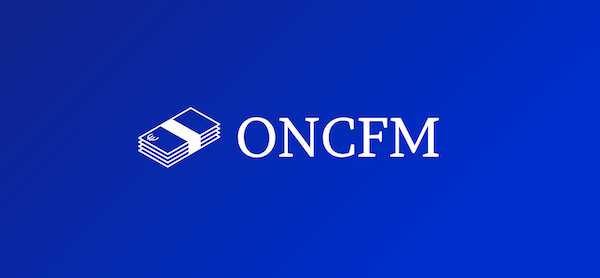

## <font color='blue'>Sommaire</font>

**[Contexte du projet et missions](#Presentation_projet)**

**[Partie 1 - Importation, Inspection et Nettoyage](#partie1)**
* [1. Importation des librairies](#1_1)
* [2. Définition des fonctions](#1_2)
* [3. Importation des données](#1_3)
* [4. Inspection des données](#1_4)

**[Partie 2 - Analyse descriptive](#partie2)**
* [1. Description des échantillons vrais et faux billets](#2_1)
* [2. Proportions de vrais et faux billets](#2_2)
* [3. Distributions des variables pour les vrais et faux billets](#2_3)
* [4. Analyse bivariée](#2_4)
* [5. Analyse exploratoire : ACP](#2_5)
* [6. Conclusion de l'analyse descriptive](#2_6)

    
**[Partie 3 - Traitement des valeurs manquantes](#partie3)**    
* [1. Echantillons d'entraînement et de test](#3_1)
* [2. Entraînement du modèle](#3_2)
* [3. Evaluation du modèle](#3_3)
* [4. Analyse des résultats](#3_4)
* [5. Imputation des valeurs manquantes](#3_5)


**[Partie 4 - Tests de différents modèles de classification](#partie4)**
* [1. Echantillons d'entraînement et de test](#4_1)
* [2. Dummy Classifier](#4_2)
* [3. Regression logistique](#4_3)
* [4. Clustering k-means](#4_4)
* [5. Random forest](#4_5)
* [6. Comparaison des différents modèles](#4_6)

**[Partie 5 - Modèle final retenu](#partie5)**


# <font color='blue'>Contexte du projet et missions<a class="anchor" id="Presentation_projet"></a></font>

L’Organisation nationale de lutte contre le faux-monnayage, ou ONCFM, est une organisation publique ayant pour objectif de mettre en place des méthodes d’identification des contrefaçons des billets en euros. Dans le cadre de cette lutte, ils souhaitent mettre en place un algorithme qui soit capable de différencier automatiquement les vrais des faux billets.

Lorsqu’un billet arrive, une machine consigne l’ensemble de ses caractéristiques géométriques. Au travers de ses années de lutte, ONCFM a observé des différences de dimensions entre les vrais et les faux billets. Ces différences sont difficilement notables à l’oeil nu, mais une machine peut sans problème arriver à les différencier.
Ainsi, l'objectif de la mission est de construire un algorithme qui, à partir des caractéristiques géométriques d’un billet, serait capable de définir automatiquement si ce dernier est un vrai ou un faux billet.

# <font color='blue'>Partie 1 - Importation et Inspection des données<a class="anchor" id="partie1"></a></font>

## <font color='green'>1. Importation des librairies<a class="anchor" id="1_1"></a></font>

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '5'

In [2]:
# Importation des librairies
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

# tests statistiques
import scipy.stats as st
import pingouin as pg

# regression lineaire et logistique
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
import statsmodels.formula.api as smf
import statsmodels.api as sm

# autocorrélation des résidus
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import durbin_watson
# colinéarité
from statsmodels.stats.outliers_influence import variance_inflation_factor
# homoscédacité
from statsmodels.stats.api import  het_breuschpagan

# analyse en composantes principales
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

# sélection du modèle
from sklearn.model_selection import GridSearchCV

#random forest, decision tree, kNN, DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

# evaluation du modèle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score
from sklearn.metrics import roc_curve, roc_auc_score, auc

## <font color='green'>2. Définition des fonctions<a class="anchor" id="1_2"></a></font>

In [3]:
# Fonction pour détecter les outliers
def detectOutlier(data,threshold):
    """Fonction pour détecter les outliers
    """
    outliers=[] # création d'une liste vide
    mean = np.mean(data)# calcul de la moyenne
    std =np.std(data)#calcul de l'écart-type
   
    for i in data:
        if std == 0:
            print('std nul')
            break
        z_score = (i - mean)/std#calcul du z-score
        if np.abs(z_score) > threshold: #valeur absolue du z-score
            outliers.append(i) # ajout de i dans la liste
    return outliers

In [4]:
def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 6))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                features[i])

    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('PC{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('PC{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    plt.title("Cercle des corrélations (PC{} et PC{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

In [5]:
def make_autopct(values):
    """Affiche les pourcentages et valeurs sur un pie chart
    """
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

## <font color='green'>3. Importation des données<a class="anchor" id="1_3"></a></font>

La démarche de l'inspection des fichiers de données est la suivante :
* Importation
* Aperçu du data frame
* Dimension du data frame

In [6]:
# Importation et aperçu du data frame
billets=pd.read_csv('billets.csv', sep=";")
billets.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

In [7]:
billets.shape

(1500, 7)

## <font color='green'>4. Inspection des données<a class="anchor" id="1_4"></a></font>

In [8]:
billets.describe(include='all')

is_genuine     diagonal  height_left  height_right   margin_low  \
count        1500  1500.000000  1500.000000   1500.000000  1463.000000   
unique          2          NaN          NaN           NaN          NaN   
top          True          NaN          NaN           NaN          NaN   
freq         1000          NaN          NaN           NaN          NaN   
mean          NaN   171.958440   104.029533    103.920307     4.485967   
std           NaN     0.305195     0.299462      0.325627     0.663813   
min           NaN   171.040000   103.140000    102.820000     2.980000   
25%           NaN   171.750000   103.820000    103.710000     4.015000   
50%           NaN   171.960000   104.040000    103.920000     4.310000   
75%           NaN   172.170000   104.230000    104.150000     4.870000   
max           NaN   173.010000   104.880000    104.950000     6.900000   

          margin_up      length  
count   1500.000000  1500.00000  
unique          NaN         NaN  
top             NaN         NaN  
freq            NaN         NaN  
mean       3.151473   112.67850  
std        0.231813     0.87273  
min        2.270000   109.49000  
25%        2.990000   112.03000  
50%        3.140000   112.96000  
75%        3.310000   113.34000  
max        3.910000   114.44000

* 'is_genuine' : variable qualitative binaire
* valeurs manquantes pour 'margin_low'
* plus grands écart-types pour 'margin_low' et 'lenght'

### Types de variables  <a class="anchor" id="1_4_1">

In [9]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


* Type de variables : correct
* Valeurs manquantes : pour la variable "margin_low"

### Valeurs manquantes  <a class="anchor" id="1_4_2">

In [10]:
billets.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

In [11]:
print("Variable 'margin_low'")
print("Pourcentage de valeurs manquantes : %.2f" % (billets.margin_low.isna().mean()*100))# Pourcentage de valeurs "NaN"

Variable 'margin_low'
Pourcentage de valeurs manquantes : 2.47


In [12]:
billets.loc[billets['margin_low'].isna()].groupby('is_genuine')['diagonal'].count()

is_genuine
False     8
True     29
Name: diagonal, dtype: int64

L'analyse des données nous permettra de définir s'il est pertinent ou non de remplacer ces valeurs manquantes, c'est-à-dire si la donnée est pertinente pour la détection des faux billets. 

### Doublons <a class="anchor" id="1_4_3">

In [13]:
billets.duplicated().sum()

0

### Valeurs aberrantes - Outliers <a class="anchor" id="1_4_4">

In [14]:
column = billets.columns[1:].to_list()

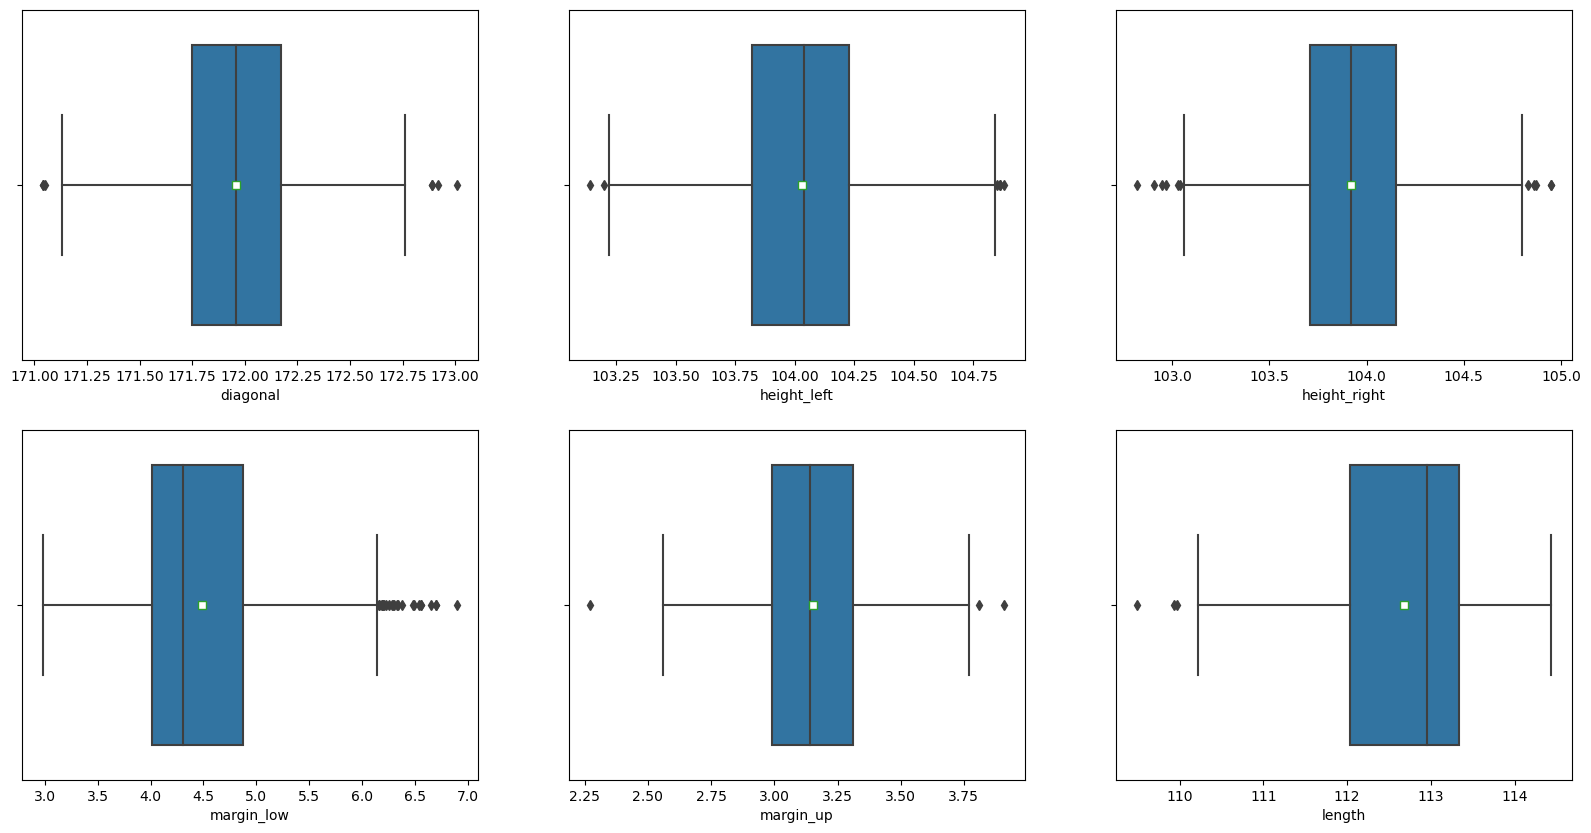

In [15]:
# Boxplots et outliers pour les différentes colonnes du df 
fig, ax = plt.subplots(2,3, figsize=(20,10))

for col, i in zip(column, range(len(column))):
    q, mod = divmod(i,3)
    sns.boxplot(data=billets, x=col, 
                showmeans=True, 
                meanprops={"marker":"s","markerfacecolor":"white"},
                ax=ax[q, mod])
plt.show()
 

In [16]:
for col in column:     
    #Application de la fonction à la série subset
    subset = billets[col]
    outliers = detectOutlier(subset,3)

    df=billets.loc[billets[col].isin(outliers), ['is_genuine',col]]
    #affichage des outliers détectés
    print()
    print("Nombre d'outliers détectés pour '" + str(col) + "' => " + str(len(outliers)))
    print(df)


Nombre d'outliers détectés pour 'diagonal' => 6
      is_genuine  diagonal
729         True    171.04
828         True    172.92
842         True    172.89
1022       False    172.89
1142       False    171.04
1277       False    173.01

Nombre d'outliers détectés pour 'height_left' => 0
Empty DataFrame
Columns: [is_genuine, height_left]
Index: []

Nombre d'outliers détectés pour 'height_right' => 4
      is_genuine  height_right
0           True        104.95
251         True        102.82
522         True        102.91
1484       False        104.95

Nombre d'outliers détectés pour 'margin_low' => 9
      is_genuine  margin_low
1027       False        6.70
1041       False        6.65
1110       False        6.56
1124       False        6.70
1169       False        6.48
1254       False        6.49
1290       False        6.90
1441       False        6.56
1464       False        6.54

Nombre d'outliers détectés pour 'margin_up' => 2
      is_genuine  margin_up
664         True      

### En conclusion :
    
* Données : 1500 lignes et 7 colonnes : 
    * is_genuine : précise la nature du billet (vrai ou faux)
    * diagonal : la diagonale du billet (en mm)
    * height_left : la hauteur du billet (mesurée sur le côté gauche, en mm)
    * height_right : la hauteur du billet (mesurée sur le côté droit, en mm)
    * margin_low : la marge entre le bord inférieur du billet et l'image de celui-ci (en mm)
    * margin_up : la marge entre le bord supérieur du billet et l'image de celui-ci (en mm)
    * length : la longueur du billet (en mm)
* Type de variables : ok
* 37 valeurs manquantes pour 'margin_low'
* Pas de doublons 
* Outliers : 
    * Les outliers sont tous des faux billets pour les variables 'margin_low' et 'length'.
    * Pour la variable 'height_right', les outliers sont en majorité des vrais billets.
    * La répartition entre vrais et faux billets pour les outliers des variables 'diagonal' et 'margin_up' est de 50-50.
    
A première vue, les valeurs minimum de 'length' et maximales de 'margin_low' caractérisent plutôt les faux billets.

# <font color='blue'>Partie 2 - Analyse descriptive et exploratoire<a class="anchor" id="partie2"></a></font>

L'objectif de l'analyse descriptive est de mieux comprendre nos données et d'identifier les caractéristiques des vrais/faux billets.

## <font color='green'>1. Description de l'échantillon<a class="anchor" id="2_1"></a></font> 

In [17]:
billets[billets.is_genuine==True].describe()

diagonal  height_left  height_right  margin_low   margin_up  \
count  1000.000000  1000.000000    1000.00000  971.000000  1000.00000   
mean    171.987080   103.949130     103.80865    4.116097     3.05213   
std       0.300441     0.300231       0.29157    0.319124     0.18634   
min     171.040000   103.140000     102.82000    2.980000     2.27000   
25%     171.790000   103.740000     103.61000    3.905000     2.93000   
50%     171.990000   103.950000     103.81000    4.110000     3.05000   
75%     172.200000   104.140000     104.00000    4.340000     3.18000   
max     172.920000   104.860000     104.95000    5.040000     3.74000   

            length  
count  1000.000000  
mean    113.202430  
std       0.359552  
min     111.760000  
25%     112.950000  
50%     113.205000  
75%     113.460000  
max     114.440000

In [18]:
billets[billets.is_genuine==False].describe()

diagonal  height_left  height_right  margin_low   margin_up  \
count  500.000000   500.000000    500.000000  492.000000  500.000000   
mean   171.901160   104.190340    104.143620    5.215935    3.350160   
std      0.306861     0.223758      0.270878    0.553531    0.180498   
min    171.040000   103.510000    103.430000    3.820000    2.920000   
25%    171.690000   104.040000    103.950000    4.840000    3.220000   
50%    171.910000   104.180000    104.160000    5.190000    3.350000   
75%    172.092500   104.332500    104.320000    5.592500    3.472500   
max    173.010000   104.880000    104.950000    6.900000    3.910000   

           length  
count  500.000000  
mean   111.630640  
std      0.615543  
min    109.490000  
25%    111.200000  
50%    111.630000  
75%    112.030000  
max    113.850000

La description des vrais et faux billets nous montre que :
* les vrais billets sont plus longs que les faux
* les faux billets ont une marge inférieure, 'margin_low', plus grande que les vrais.
* la diagonale est très proche entre les vrais et faux billets
* les hauteurs droites et gauches sont légèrement supérieures pour les faux billets.

## <font color='green'>2. Proportions de vrais et faux billets<a class="anchor" id="2_2"></a></font> 

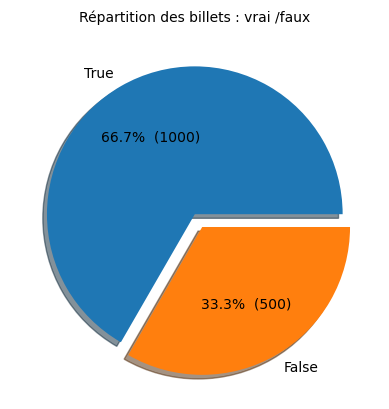

In [19]:
# Proportion de faux billets
data = billets['is_genuine'].value_counts()

plt.pie(data, 
        labels=['True','False'],
        autopct=make_autopct(data),
        textprops={'fontsize': 10},
        explode=(0,0.1), 
        shadow=True)

plt.title("Répartition des billets : vrai /faux",fontsize=10)

plt.show()

## <font color='green'>3. Distributions des variables pour les vrais et faux billets<a class="anchor" id="2_3"></a></font> 

* Caractéristiques dimensionnelles des faux billets : 
    * moins long et plus haut (diagonale équivalente aux vrais)
    * marges supérieure et inférieure plus grandes
    * Les distributions vrais et faux billets sont les mieux séparées pour margin_low et length.

* **Histogramme :**

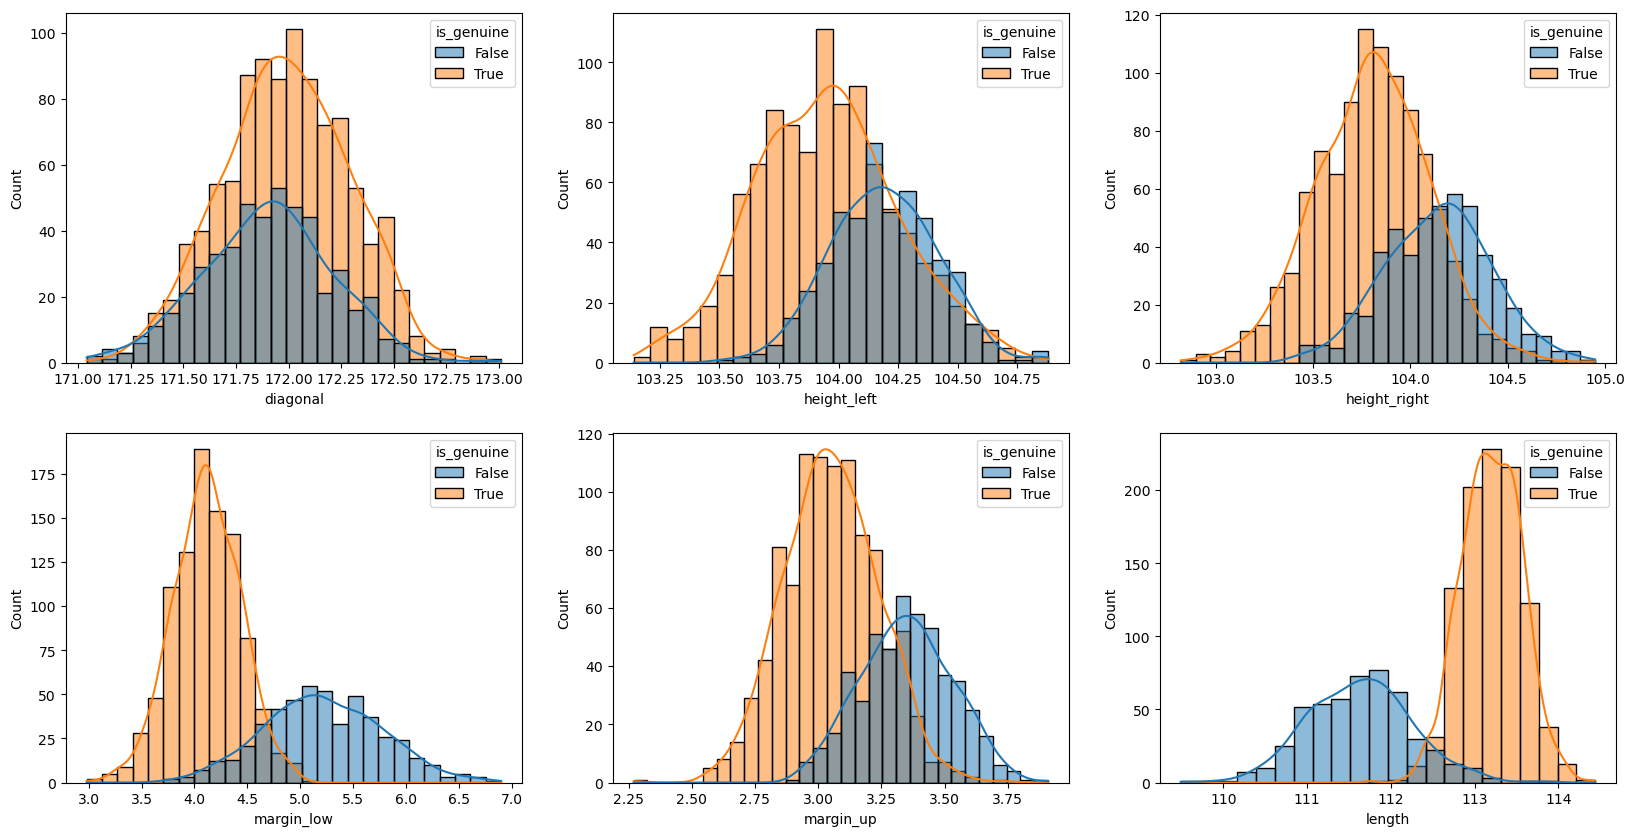

In [20]:
# Distribution des dimensions
fig, ax = plt.subplots(2,3, figsize=(20,10))

for col, i in zip(column, range(len(column))):
    q, mod = divmod(i,3)
    sns.histplot(data=billets, x=col, hue='is_genuine', kde=True, ax=ax[q, mod])
plt.show()

* **Normalité :**

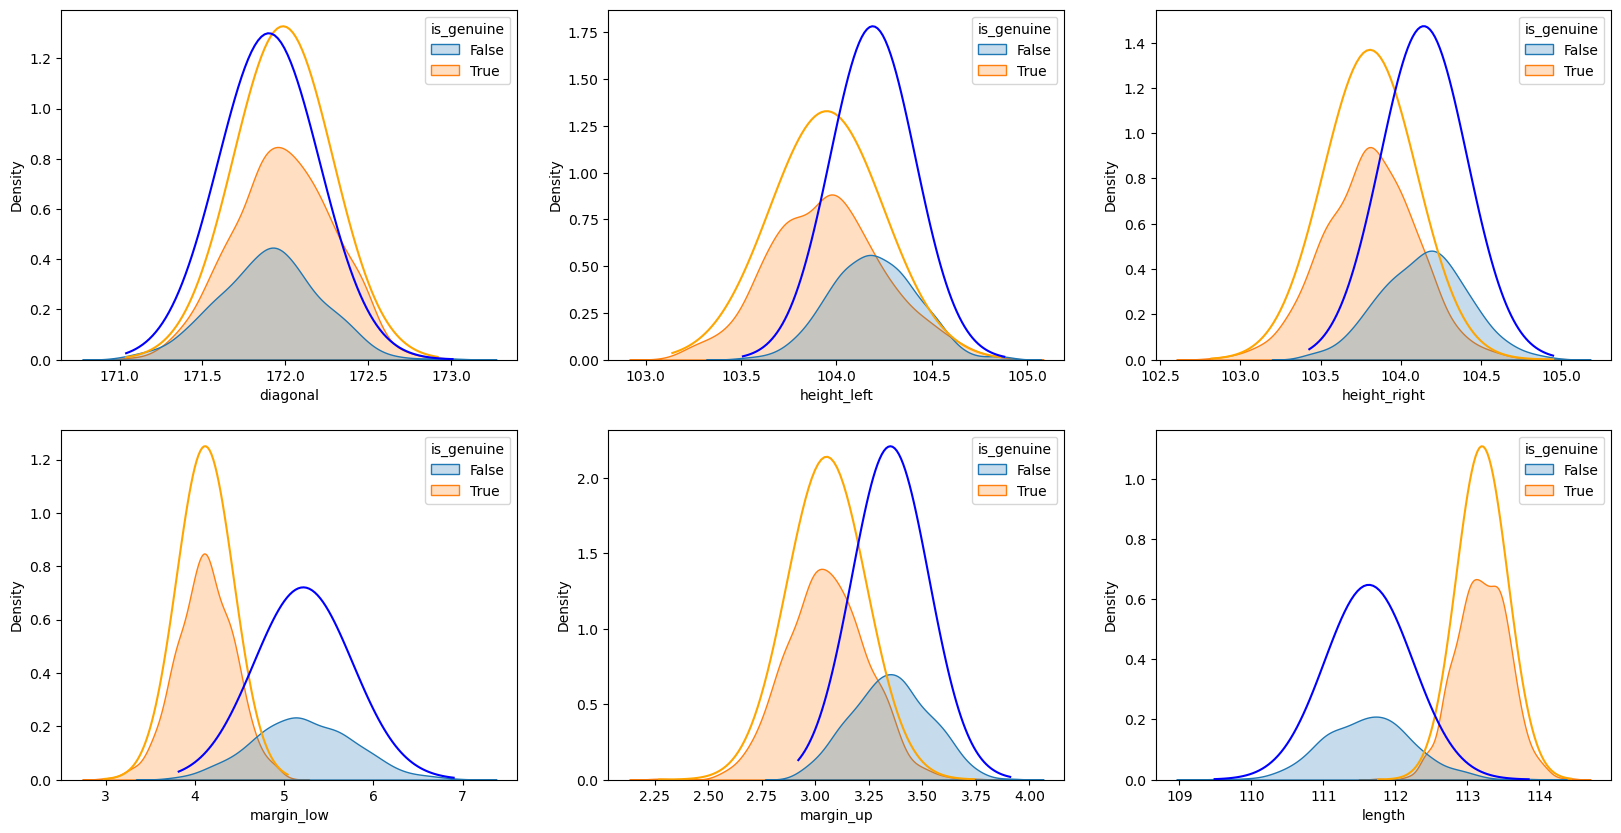

In [21]:
# Distribution des dimensions
fig, ax = plt.subplots(2,3, figsize=(20,10))

for col, i in zip(column, range(len(column))):
    q, mod = divmod(i,3)
    sns.kdeplot(data=billets, x=col, fill=True, hue='is_genuine', ax=ax[q, mod])
    
    # Distribution normale vrais billets
    X = billets.loc[billets['is_genuine']==True, col]
    x_min = min(X)
    x_max = max(X)
    mean = X.mean()
    std = X.std()
    x = np.linspace(x_min, x_max, 100)
    y = st.norm.pdf(x,mean,std)
    ax[q, mod].plot(x,y, color='orange',label='Distribution normale', )
    
    # Distribution normale vrais billets
    X = billets.loc[billets['is_genuine']==False,col]
    x_min = min(X)
    x_max = max(X)
    mean = X.mean()
    std = X.std()
    x = np.linspace(x_min, x_max, 100)
    y = st.norm.pdf(x,mean,std)
    ax[q, mod].plot(x,y, color='blue',label='Distribution normale')
plt.show()

In [22]:
# Test de normalité de Shapiro-Wilk
for col in column:
    print('')
    print('-'*100)
    
    print('Vrais billets - Variable :',col)
    k2, p = st.shapiro(billets.loc[billets['is_genuine']==True, col])
    alpha = 0.05
    print("p = ",p)
    if p < alpha:  # H0 : la variable suit la loi normale de distribution
        print("H0 peut être rejetée : la distribution ne suit pas la loi normale.")
    else:
        print("H0 est acceptée : la distribution suit la loi normale")
        
    print('Faux billets - Variable :',col)
    k2, p = st.normaltest(billets.loc[billets['is_genuine']==False, col])
    alpha = 0.05
    print("p = ",p)
    if p < alpha:  # H0 : la variable suit la loi normale de distribution
        print("H0 peut être rejetée : la distribution ne suit pas la loi normale.")
    else:
        print("H0 est acceptée : la distribution suit la loi normale")


----------------------------------------------------------------------------------------------------
Vrais billets - Variable : diagonal
p =  0.3102126121520996
H0 est acceptée : la distribution suit la loi normale
Faux billets - Variable : diagonal
p =  0.7295900609011197
H0 est acceptée : la distribution suit la loi normale

----------------------------------------------------------------------------------------------------
Vrais billets - Variable : height_left
p =  0.028511906042695045
H0 peut être rejetée : la distribution ne suit pas la loi normale.
Faux billets - Variable : height_left
p =  0.8314115584405727
H0 est acceptée : la distribution suit la loi normale

----------------------------------------------------------------------------------------------------
Vrais billets - Variable : height_right
p =  0.5872448086738586
H0 est acceptée : la distribution suit la loi normale
Faux billets - Variable : height_right
p =  0.925607587612893
H0 est acceptée : la distribution suit 

<div class="alert alert-block alert-info">
    
Pour chaque catégorie de billets : Toutes les variables suivent la loi normale sauf height_left pour les vrais billets. 

Cependant, l'observation de la distribution, le fait qu'elles ne soit pas très différente d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que la distribution peut être considérée comme suivant une loi normale.
    
</div>

* **Boxplots :**

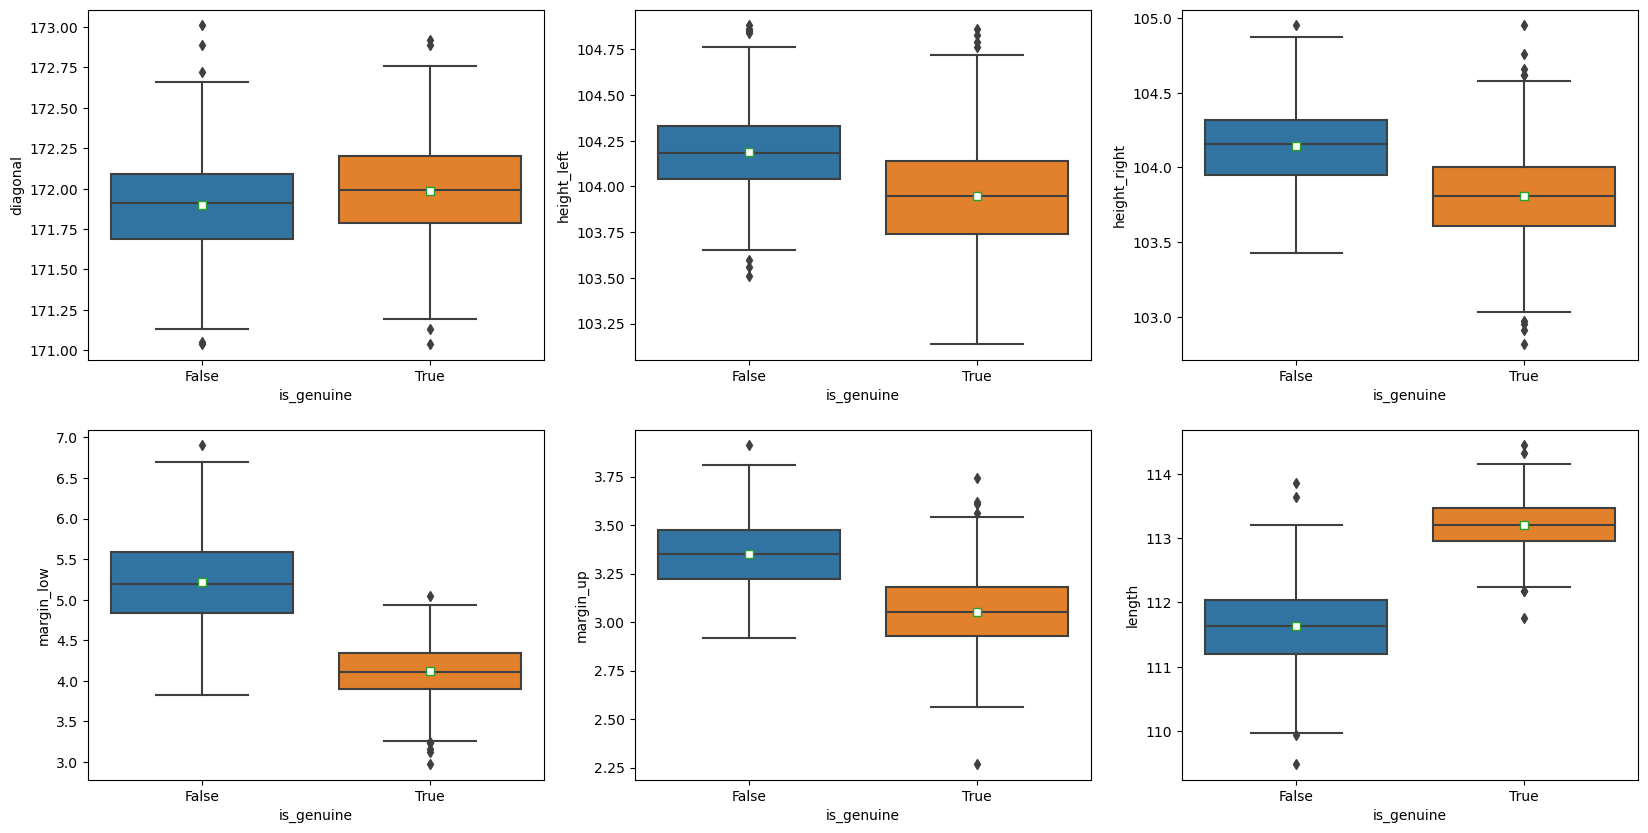

In [23]:
fig, ax = plt.subplots(2,3, figsize=(20,10))

for col, i in zip(column, range(len(column))):
    q, mod = divmod(i,3)
    sns.boxplot(data=billets, x='is_genuine', y = col,
                showmeans=True, 
                meanprops={"marker":"s","markerfacecolor":"white"},
                ax=ax[q, mod])
    
plt.show()

Nous retrouvons pour les graphiques margin_low - length des nuages de points bien séparés entre vrais et faux billets.

## <font color='green'>4. Analyse bi-variée<a class="anchor" id="2_4"></a></font> 

### Comparaison des moyennes des vrais et faux billets

Pour mieux visualiser les différences entre les vrais et les faux billets, représentons les moyennes sur un radar chart.

In [24]:
X = billets[['diagonal', 'height_left', 'height_right', 'margin_low','margin_up', 'length']].values
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']

scaler = StandardScaler() # Instanciation du scaler
X_scaled = scaler.fit_transform(X)

In [25]:
# df avec les moyennes (valeurs centrées - reduites pour la représentation sur le radar chart)
df_mean_scaled = pd.DataFrame(X_scaled,
                              index = billets.is_genuine,
                              columns = features )
df_mean_scaled = df_mean_scaled.reset_index().groupby('is_genuine').mean()
df_mean_scaled = df_mean_scaled.T.reset_index(names='vars').round(2)
df_mean_scaled

is_genuine          vars  False  True
0               diagonal  -0.19  0.09
1            height_left   0.54 -0.27
2           height_right   0.69 -0.34
3             margin_low   1.10 -0.56
4              margin_up   0.86 -0.43
5                 length  -1.20  0.60

In [26]:
#visualisation sur un radar
theta=df_mean_scaled['vars']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r= df_mean_scaled[0],
      theta= theta,
      fill='toself',
      name='Faux billets'
    ))

fig.add_trace(go.Scatterpolar(
      r= df_mean_scaled[1],
      theta= theta,
      fill='toself',
      name='Vrais billets'
    ))


fig.update_layout(polar=dict(radialaxis=dict(visible=True)),
                  showlegend=True)
                  
      
fig.show()

<div class="alert alert-block alert-info">
    
Le radar chart montre que : 
* les vrais billets sont :
    * **plus long**
    * diagonale plus grande
    * hauteurs droite et gauche plus petites
    * **marges haute et basse plus petites**
* les faux billets sont donc :
    * **moins long**
    * diagonale plus faible
    * hauteurs droite et gauche plus grandes
    * **marges haute et basse plus grandes**
    
<div>

* **Test statistique de l'égalité des moyennes des vrais et faux billets** 

Pour vérifier les différences entre les moyennes des échantillons vrais et faux billets, nous pouvons effectuer un test statistique.

Pour définir quel test effectué, il nous faut vérifier si les données des 2 échantillons sont :
* indépendantes et continues
* distribuées normalement
* de variances similaires 

* **Variance :** Variances égales pour 'diagonal', height_right' et 'margin_up' uniquement

In [27]:
# Egalité des variances
equal_var = []
for col in column:
    print('')
    print('-'*100)
    print('Variable :',col)
    print("Vrais billets : var = %.3f" % np.var(billets.loc[billets['is_genuine']==True, col]))
    print("Faux billets : var = %.3f" % np.var(billets.loc[billets['is_genuine']==False, col]))
    print(pg.homoscedasticity(data=billets, dv=col, group='is_genuine'))
    equal_var.append(pg.homoscedasticity(data=billets, dv=col, group='is_genuine').iloc[0,2])


----------------------------------------------------------------------------------------------------
Variable : diagonal
Vrais billets : var = 0.090
Faux billets : var = 0.094
               W      pval  equal_var
levene  0.010911  0.916822       True

----------------------------------------------------------------------------------------------------
Variable : height_left
Vrais billets : var = 0.090
Faux billets : var = 0.050
                W          pval  equal_var
levene  42.731858  8.585413e-11      False

----------------------------------------------------------------------------------------------------
Variable : height_right
Vrais billets : var = 0.085
Faux billets : var = 0.073
               W      pval  equal_var
levene  1.918263  0.166254       True

----------------------------------------------------------------------------------------------------
Variable : margin_low
Vrais billets : var = 0.102
Faux billets : var = 0.306
         W  pval  equal_var
levene NaN   NaN 

* **T-test**:  variances non égales => t-test de Welch et variances égales => t-test de Student

Pour toutes les variables, les moyennes ne sont pas égales.

In [28]:
# t-test 
for col, equal in zip(column, equal_var):
    print('')
    print('-'*100)
    print('Variable :',col)
    X1 = billets.loc[billets['is_genuine']==True, col]
    X2 = billets.loc[billets['is_genuine']==False, col]
    t,p = st.ttest_ind(X1,X2, equal_var=equal)
    print(t,p)

    alpha = 0.05

    if p < alpha:  # H0 : 
        print("H0 peut être rejetée : les moyennes ne sont pas égales")
    else:
        print("H0 est acceptée : les moyennes sont égales")


----------------------------------------------------------------------------------------------------
Variable : diagonal
5.184087524514633 2.4668667372034535e-07
H0 peut être rejetée : les moyennes ne sont pas égales

----------------------------------------------------------------------------------------------------
Variable : height_left
-17.48660281591907 1.415362997565114e-61
H0 peut être rejetée : les moyennes ne sont pas égales

----------------------------------------------------------------------------------------------------
Variable : height_right
-21.470310019402618 2.2708556903459502e-89
H0 peut être rejetée : les moyennes ne sont pas égales

----------------------------------------------------------------------------------------------------
Variable : margin_low
nan nan
H0 est acceptée : les moyennes sont égales

----------------------------------------------------------------------------------------------------
Variable : margin_up
-29.50561631725463 3.144530308715909e-1

<div class="alert alert-block alert-info">
    
**Conclusion** : Les résultats des tests montrent bien qu'il y a un lien entre vrais / faux billets et les dimensions des billets.
    
<div>

### Matrice des corrélations

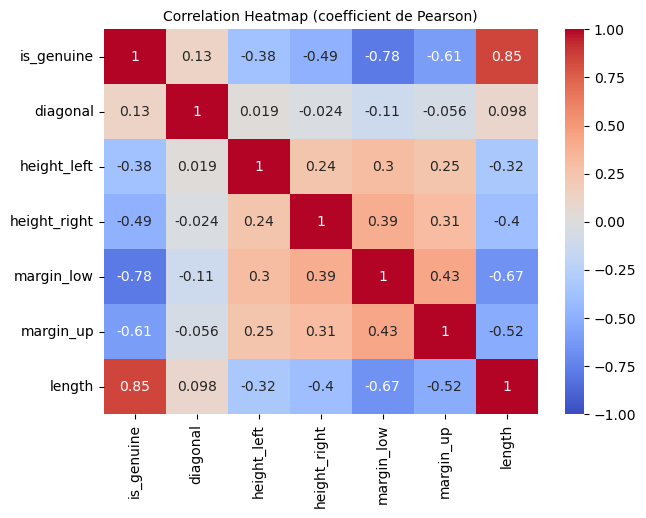

In [29]:
# Calcul du coefficient de corrélation de Pearson et représentation sous forme de heatmap
plt.figure(figsize=(7,5))
heatmap = sns.heatmap(billets.corr(method='pearson'), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Correlation Heatmap (coefficient de Pearson)', fontdict={'fontsize':10})
plt.show()

La matrice de corrélation montre des coefficients de corrélation les plus élevés entre la nature du billet, 'is_genuine', et les dimensions 'margin_low', 'length' et 'margin_up'.

### Représentation bivariée 

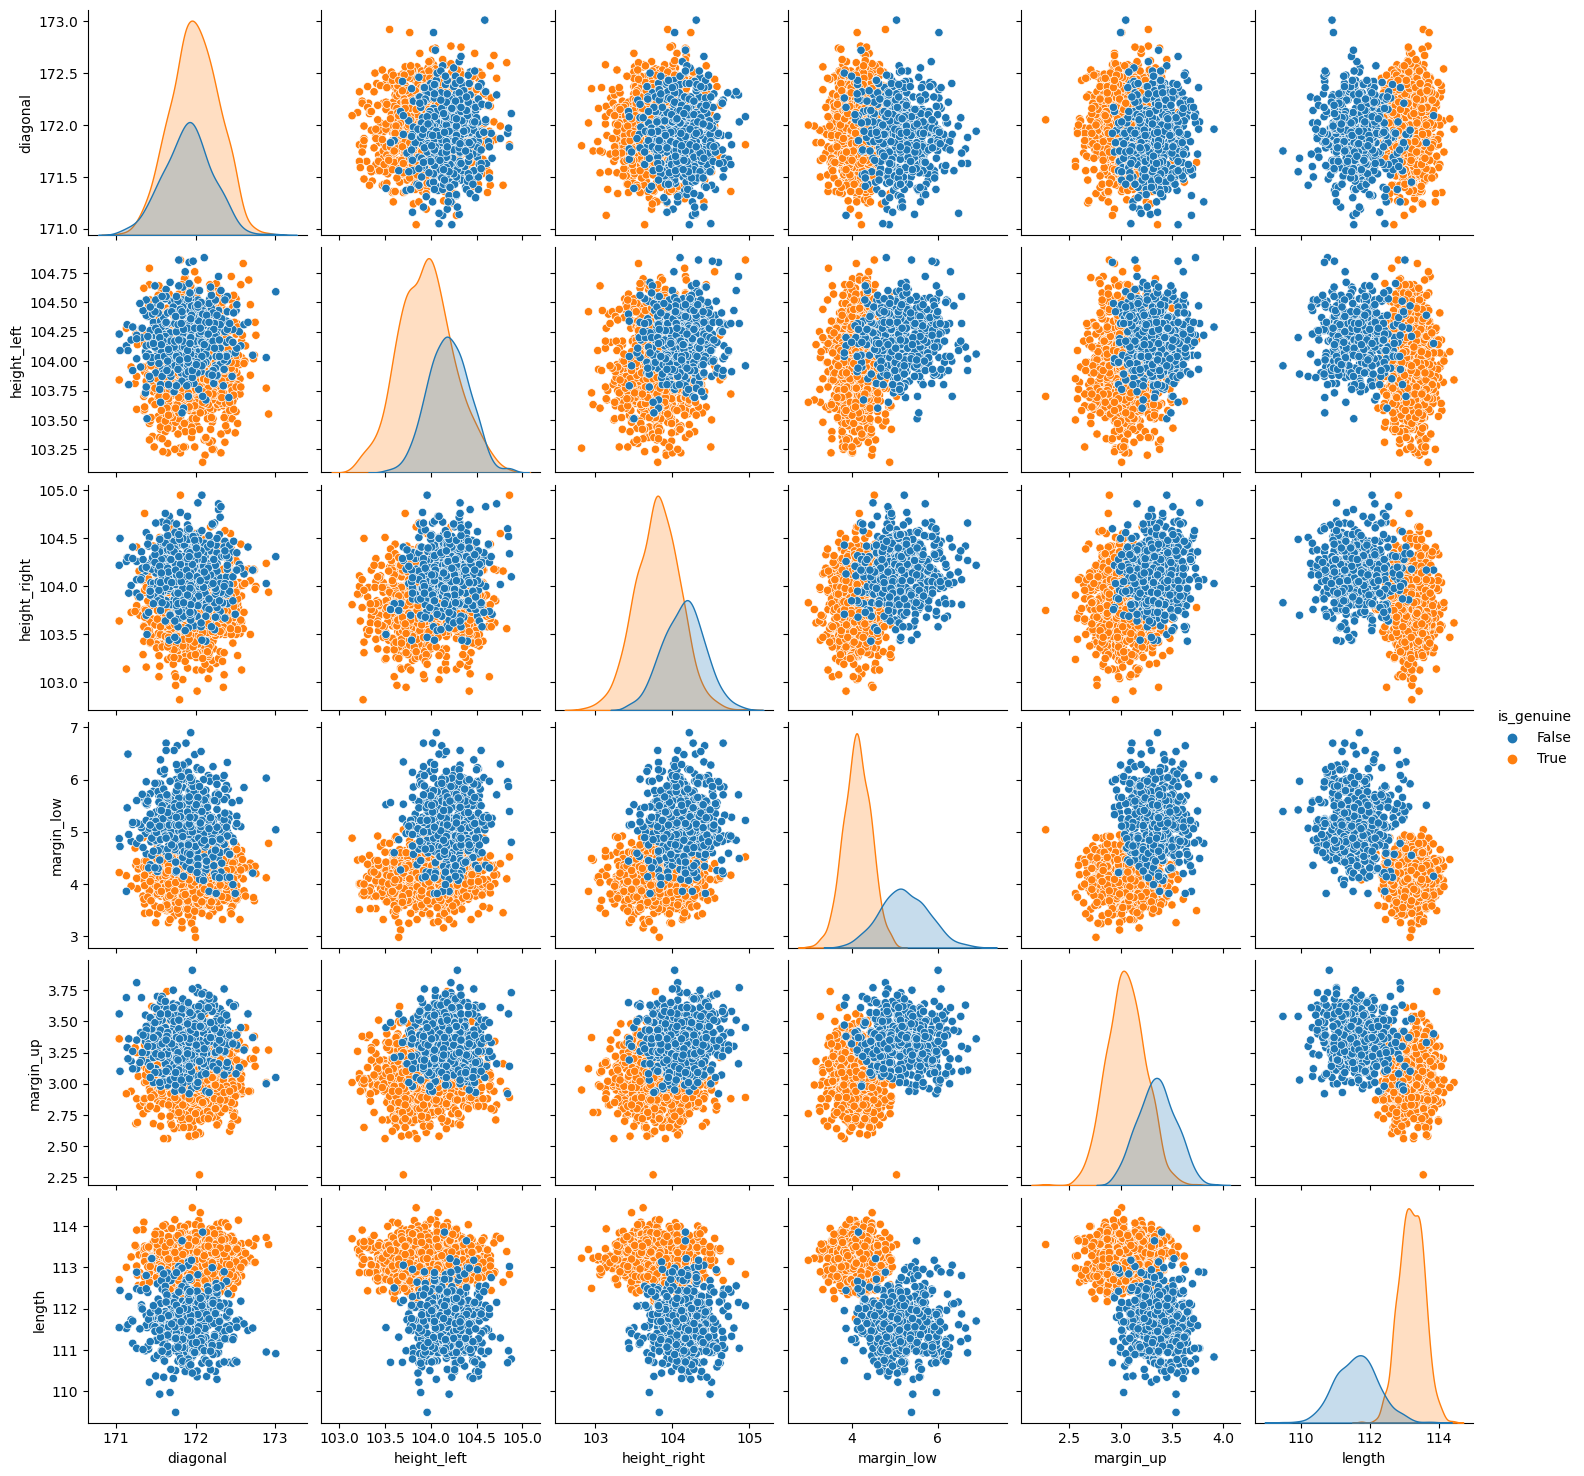

In [30]:
sns.pairplot(data=billets, hue='is_genuine', x_vars = column, y_vars = column )
plt.show()

 ## <font color='green'>5. Analyse exploratoire : ACP<a class="anchor" id="2_5"></a></font> 

La réduction de dimensions n'est pas nécessaire dans notre cas car nous avons peu de variables. 

L'Analyse en Composantes Principales peut cependant nous apporter :
* une meilleure visualisation de nos données 
* des informations complémentaires sur nos variables

L'ACP sera menée sur le dataframe sans les valeurs manquantes.

In [31]:
# Mettre la colonne 'is_genuine' en index
df_acp = billets.loc[~billets['margin_low'].isna()].set_index('is_genuine')
df_acp

diagonal  height_left  height_right  margin_low  margin_up  length
is_genuine                                                                    
True          171.81       104.86        104.95        4.52       2.89  112.83
True          171.46       103.36        103.66        3.77       2.99  113.09
True          172.69       104.48        103.50        4.40       2.94  113.16
True          171.36       103.91        103.94        3.62       3.01  113.51
True          171.73       104.28        103.46        4.04       3.48  112.54
...              ...          ...           ...         ...        ...     ...
False         171.75       104.38        104.17        4.42       3.09  111.28
False         172.19       104.63        104.44        5.27       3.37  110.97
False         171.80       104.01        104.12        5.51       3.36  111.95
False         172.06       104.28        104.06        5.17       3.46  112.25
False         171.47       104.15        103.82        4.63       3.37  112.07

[1463 rows x 6 columns]

### Séparation des données

In [32]:
# Séparation des données
X = df_acp.values # Matrice des données 

X.shape # Vérifier la dimension

names = df_acp.index # Noms des individus

features = df_acp.columns # Noms des variables

p = df_acp.shape[1] # nb de variables

### Détermination du nombre de composantes

In [33]:
# Instanciation
Std_scaler = StandardScaler()

# Fit and transform
X_scaled = Std_scaler.fit_transform(X)

# Visualisation de la moyenne et de l'écart-type : attendu moy = 0 et std =1
idx = ["mean", "std"]
pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

0    1    2    3    4    5
mean  0.0  0.0  0.0  0.0 -0.0 -0.0
std   1.0  1.0  1.0  1.0  1.0  1.0

In [34]:
# Instanciation de l'ACP
pca = PCA()

# Entraînement sur les données scalées
pca.fit(X_scaled)

PCA()

In [35]:
scree = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(p)], 
        "Variance expliquée" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    }
)
scree

Dimension  Variance expliquée  % variance expliquée  % cum. var. expliquée
0      Dim1            2.589181                  43.0                   43.0
1      Dim2            1.018936                  17.0                   60.0
2      Dim3            0.788724                  13.0                   73.0
3      Dim4            0.708014                  12.0                   85.0
4      Dim5            0.577616                  10.0                   95.0
5      Dim6            0.321632                   5.0                  100.0

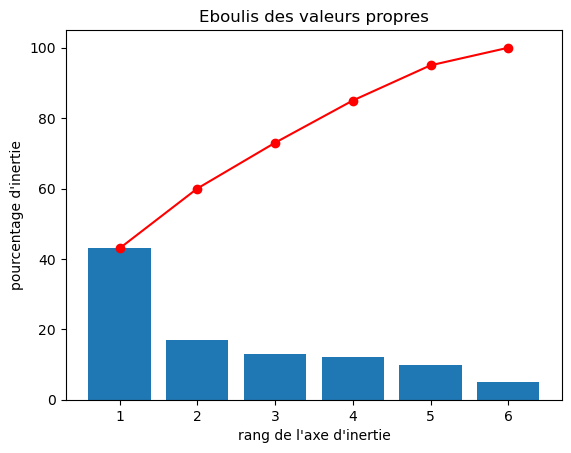

In [36]:
# liste des composants (indice des composantes)
x_list = range(1, p+1)
list(x_list)

# Représentation graphiques des valeurs propres
plt.bar(x_list, scree['% variance expliquée'])
plt.plot(x_list, scree['% cum. var. expliquée'],c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

La première composante explique 40% de la variances des données.

### ACP

In [37]:
# Nombre de composantes principales 
n_components = 2

# Instanciation de l'ACP
pca = PCA(n_components=n_components)

# Entraînement sur les données scalées
pca.fit(X_scaled)

PCA(n_components=2)

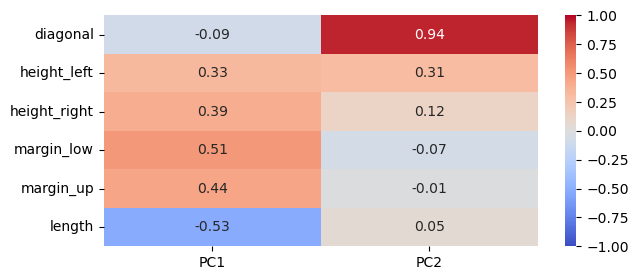

In [38]:
# Principal Components = PCs
pcs = pd.DataFrame(pca.components_)

# affichage de 'features' pour les colonnes et PCi en index
pcs.columns = features

# liste des composants (indice des composantes)
x_list = range(1, n_components+1)
list(x_list)

pcs.index = [f"PC{i}" for i in x_list]
pcs.round(2)

# Représentation sous forme de heatmap des 5 premières composantes
fig, ax = plt.subplots(figsize=(7, 3))
sns.heatmap(pcs.T.iloc[:,:5], vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")
plt.show()

Nous retrouvons les variables 'length', 'margin_low' et 'margin_up' dans la première composante comme variable les plus pertinentes pour décrire le jeu de données. La variable 'diagonal' n'est pas bien présentée dans la première composante.

La deuxième composante reprend essentiellement la variable 'diagonal'.

### Cercle des corrélations

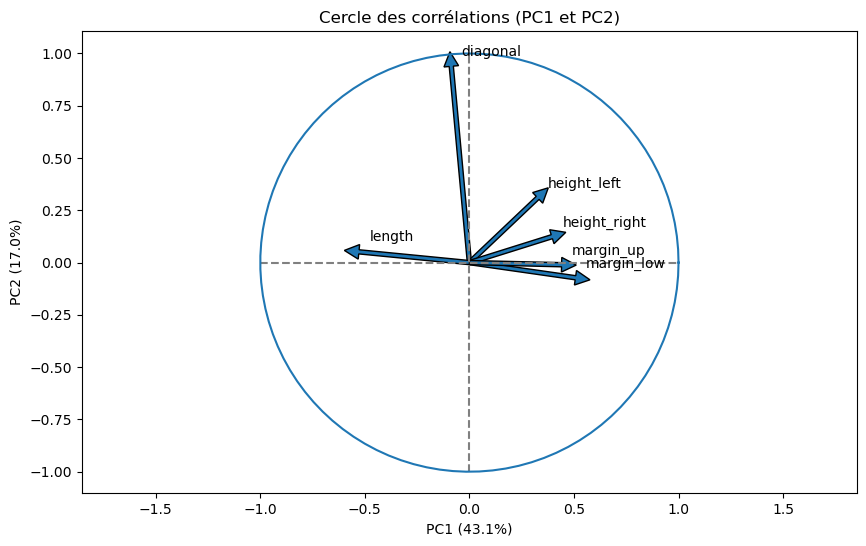

In [39]:
# Graphe de corrélation pour PC1 et PC2
correlation_graph(pca, (0,1), features)

### Projection sur le premier plan factoriel

In [40]:
X_proj = pca.transform(X_scaled)

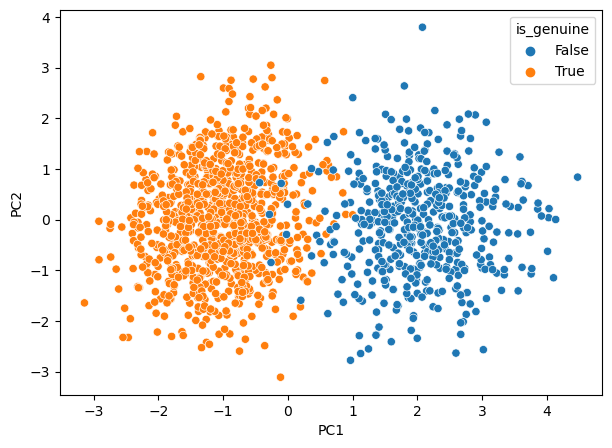

In [41]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=None, x=X_proj[:, 0],y=X_proj[:, 1], hue=df_acp.index)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

Nous observons que la première composante seule permet de séparer les vrais et faux billets : la longueur et les marges inférieures et supérieures sont donc bien des variables pertinentes pour la classification.

Concernant la visualisation, le graphique 'margin_low' en fonction de 'length' peut être conservé pour la visualisation ultérieure des résultats de classification.

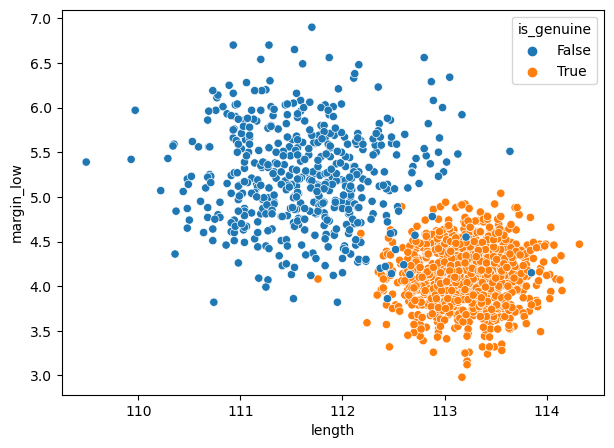

In [42]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=df_acp, x='length',y='margin_low',hue=df_acp.index)
plt.show()

## <font color='green'>6. Conclusions de l'analyse <a class="anchor" id="2_6"></a></font> 

* Répartition : 2/3 vrais billets, 1/3 faux billets
* Caractéristiques dimensionnelles des faux billets : 
    * 'length' plus petite
    * 'height_right', 'heigh_left' plus grandes
    * 'margin_up', 'margin_low' plus grandes 
    * 'diagonal' ne permet pas de différencier la catégorie des billets
* Les variables qui permettent le mieux de différencier les vrais des faux billets sont : margin_low et length.
    * pics sépararés sur l'histogramme
    * que des faux billets dans les outliers pour ces variables
    * nuages de points bien séparés sur les graphiques margin_low vs length
* La catégorie des billets est fortement corrélée aux variables 'length', 'margin_low', 'margin_up'. D'autres variables sont également corrélées comme 'margin_low' et 'length'.
* Les variables les mieux représentées sur la première composante de l'ACP sont (par représentation décroissante) : 'length', 'margin_low', 'margin_up', 'height_right'

En conclusion, les variables les plus pertinentes pour différencier les vrais des faux billets sont : 'length', 'margin_low', 'margin_up'.

=> Pour le traitement des valeurs manquantes, 'margin_low' est une variable importante : une imputation est donc à réaliser.

# <font color='blue'>Partie 3. Traitement des valeurs manquantes<a class="anchor" id="Partie 3"></a></font>

Nous allons maintenant traiter les valeurs manquantes de la variable 'margin_low'.

* 3 méthodes d'imputation des valeurs manquantes ont été étudiées *( * ) : voir notebook complet*:
    * remplacement par la moyenne (*)
    * régression linéaire simple (*)
    * régression linaire multiple
* Seule l'imputation par la regression linéaire multiple est présentée ici.
* La variable 'is_genuine' ne sera pas considérée pour la définition des modèles de régression. Seules les variables de dimensions seront considérées.

In [43]:
# df sans les lignes avec les valeurs manquantes
billets_NaN = billets.copy()
billets_NaN = billets_NaN.loc[~billets_NaN['margin_low'].isna()]

## <font color='green'>1. Echantillons d'entraînement et de test<a class="anchor" id="3_1"></a></font>

In [44]:
# Définition des variables X et y 
X = billets_NaN[['diagonal', 'height_left', 'height_right', 'margin_up', 'length']]
y = billets_NaN['margin_low']

# Variable pour stratification du modèle 
# répartition homogène de vrais et faux billets dans les échantillons des tests et entraînement
stratify_var = billets_NaN['is_genuine']

In [45]:
# Création de l'échantillon d'entraînement et de l'échantillon de test
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, stratify=stratify_var, random_state=42)

In [46]:
# vérification de la stratification
train_index = X_train.index.to_list()# récupération des index 
test_index = X_test.index.to_list()

print("Répartition vrais/faux billets dans les échantillons d'entraînement et de test")
train_prop = billets_NaN.loc[billets_NaN.index.isin(train_index),'is_genuine'].value_counts()/len(X_train)*100
print("Echantillon X_train : Size = %.f, True = %.1f, False = %.1f" % (X_train.shape[0], train_prop[0],train_prop[1]) )
test_prop = billets_NaN.loc[billets_NaN.index.isin(test_index),'is_genuine'].value_counts()/len(X_test)*100
print("Echantillon X_test : Size = %.f, True = %.1f, False = %.1f" % (X_test.shape[0], test_prop[0],test_prop[1]) )

Répartition vrais/faux billets dans les échantillons d'entraînement et de test
Echantillon X_train : Size = 1170, True = 66.4, False = 33.6
Echantillon X_test : Size = 293, True = 66.2, False = 33.8


## <font color='green'>2. Entraînement du modèle<a class="anchor" id="3_2"></a></font>

In [47]:
# Echantillon d'entraînement
train = billets_NaN.loc[billets_NaN.index.isin(train_index)]

In [48]:
reg_multi = smf.ols(formula='margin_low ~ diagonal + height_left + height_right + margin_up + length', data=train).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.471
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     206.9
Date:                Sun, 06 Aug 2023   Prob (F-statistic):          6.30e-158
Time:                        18:50:54   Log-Likelihood:                -800.89
No. Observations:                1170   AIC:                             1614.
Df Residuals:                    1164   BIC:                             1644.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       21.5011     10.879      1.976   

<div class="alert alert-block alert-info">
    
* Significativité : 
Toutes les p-values sont < 0.05 : l'hypothèse de nullité des paramètres est rejettée. Tous les paramètres sont significatifs.
* Coefficient de détermination :
Le coefficient $R^{2}$ est de l'ordre de 0.5 : cela n'est pas très élevé.
* Colinéarité : 
Un problème de colinéarité est suspecté.
    
<div>

## <font color='green'>3. Evaluation du modèle<a class="anchor" id="3_3"></a></font>

In [49]:
# Test et Evaluation du modèle
y_predict = reg_multi.predict(X_test) 

r_squared = r2_score(y_test,y_predict)
print("Coefficient de détermination R2 = %.2f" % r_squared)

Coefficient de détermination R2 = 0.50


<div class="alert alert-block alert-info">
    
Coefficient de détermination : Le coefficient $R^{2}$ est de l'ordre de 0.5 pour l'échantillon de test: cela n'est pas très élevé. Seulement 50% de la distribution des données est expliquée par le modèle.
<div>

###### Représentation de margin_low ajusté  en fonction de margin_low

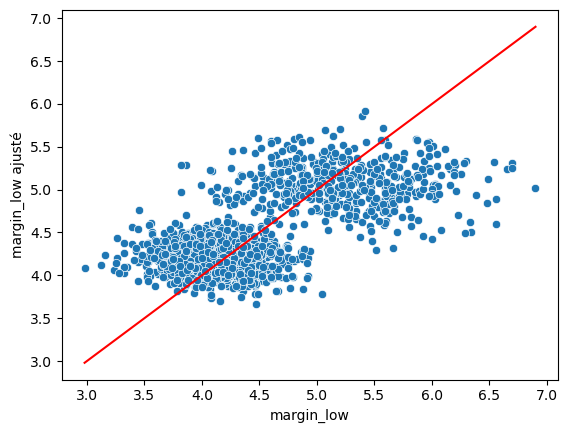

In [50]:
X = billets_NaN[['diagonal','height_left', 'height_right', 'margin_up', 'length']]
y = billets_NaN['margin_low']
y_predict_reg_multi = reg_multi.predict(X)
y_plot = [y.min(), y.max()]
ax = sns.scatterplot(x=y, y=y_predict_reg_multi)
ax.set(xlabel='margin_low', ylabel='margin_low ajusté')
plt.plot(y_plot, y_plot, color='r')
plt.show()

Nous pouvons voir, en effet, que le modèle n'est pas parfait : les points ne sont pas alignés sur la bissectrice. Cela est cohérent avec le coefficient de détermination de 0.5.

## <font color='green'>4. Analyse des résultats<a class="anchor" id="3_4"></a></font>

### 4.1. Colinéarité des variables<a class="anchor" id="3_4_1"></a>

Nous allons tester la colinéarité des variables car une multicolinéarité est suspectée (voir reg_multi.summary()).

In [51]:
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.0128438433767395,
 1.1415032962021772,
 1.2413308582939393,
 1.3995661197595373,
 1.559682996363529]

<div class="alert alert-block alert-info">
Les facteurs d'inflation de la variance sont tous <2 : la multi-colinéarité est très faible. Les facteurs ne sont pas influencés par la corrélation avec d'autres facteurs.
<div>    

### 4.2. Analyse des résidus<a class="anchor" id="3_4_2"></a>

Le test d’évaluation de la significativité du lien linéaire entre les variables est valide, si les résidus :
* sont indépendants (pas de corrélation entre les résidus et les valeurs prédites)
* sont distribués selon une loi Normale de moyenne 0
* sont distribués de façon homogènes, c’est à dire, avec une variance constante

#### Indépendance des résidus

Les modèles supposent que les résidus ne sont pas corrélés: $Cov(e_i,e_j) = 0$, $i ≠ j$


<Figure size 700x300 with 0 Axes>

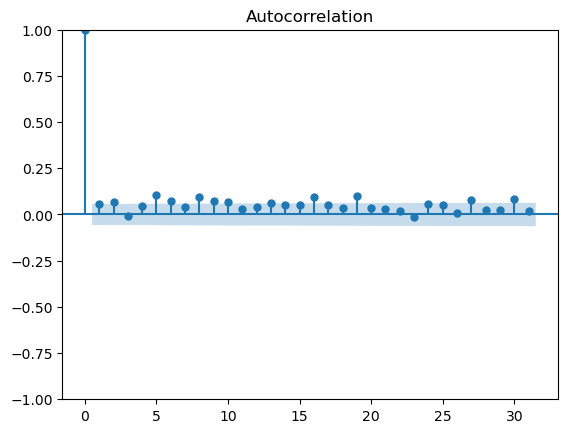

In [52]:
# Graphique d'autocorrélation des résidus
plt.figure(figsize=(7,3))
plot_acf(reg_multi.resid)
plt.show()

Pour tester l'autocorrélation des résidus, nous allons réaliser le test de Durbin-Watson. 
Le résultat du test est compris entre 0 et 4 :
* ~2 : pas d'autocorrélation
* 0 < D-W < 2 : autocorrélation postive
* 2 < D-W < 4 : autocorrélation négative

In [53]:
# Durbin-Watson test
print(durbin_watson(reg_multi.resid))

1.8887557958766308


<div class="alert alert-block alert-info">
La statistique de Durbin-Watson est proche de 2 : l'autocorrélation des résidus est faible.
<div>

#### Normalité des résidus

In [54]:
# Résidus standards
residus_multi_std = reg_multi.resid/np.sqrt(sum(reg_multi.resid**2)/(len(reg_multi.resid)-1))

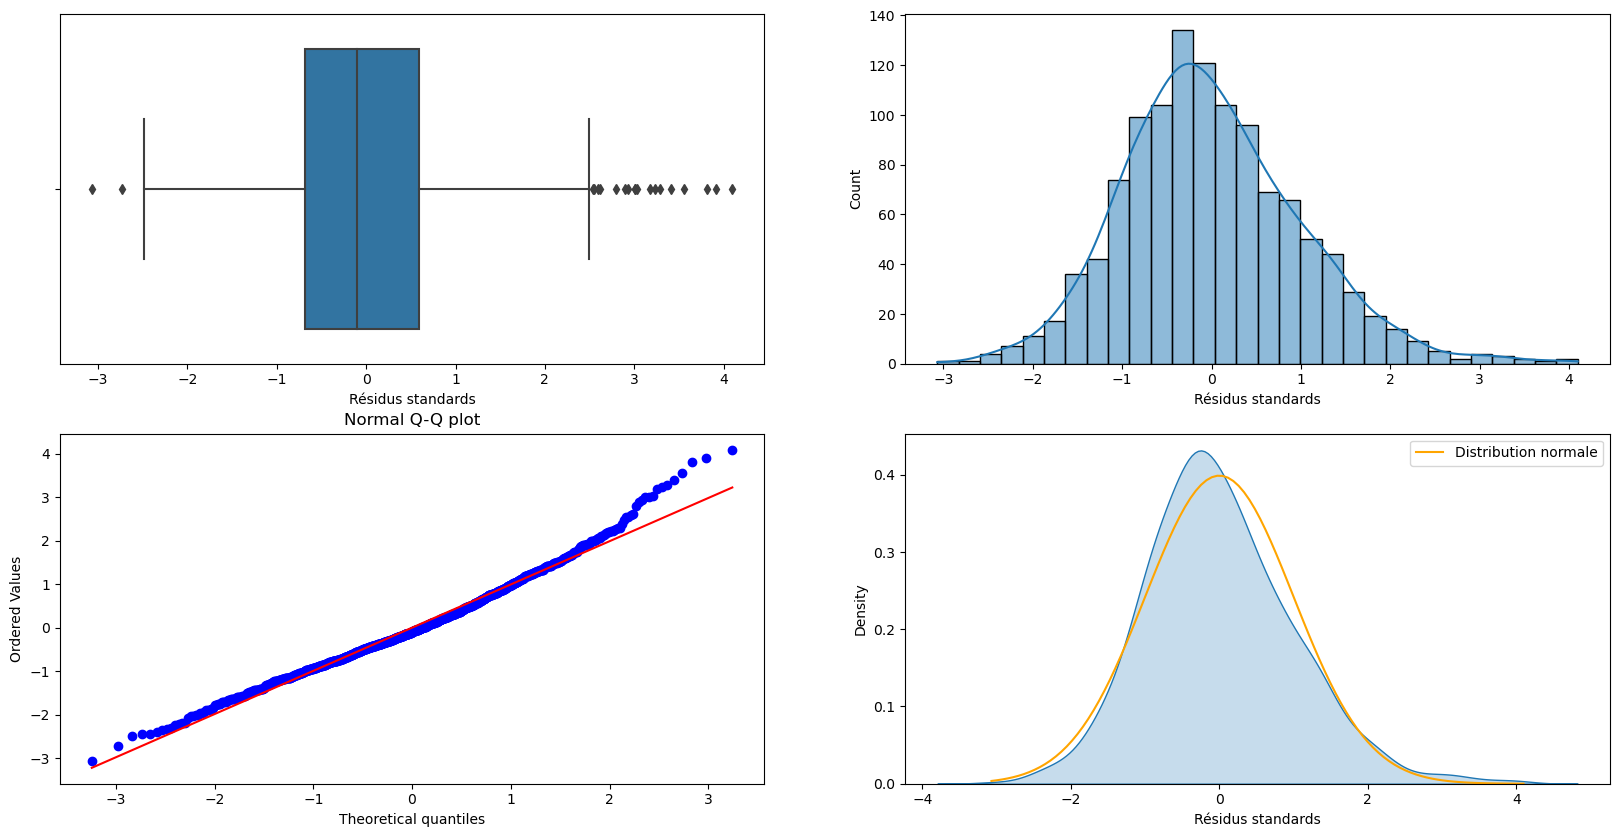

In [55]:
# Distribution des résidus
fig, ax = plt.subplots(2,2,figsize=(20,10))
sns.boxplot(x=residus_multi_std, ax=ax[0,0])
ax[0,0].set_xlabel("Résidus standards")
sns.histplot(x=residus_multi_std, ax=ax[0,1], kde=True)
ax[0,1].set_xlabel("Résidus standards")

# Diagramme Quantile Quantile
st.probplot(residus_multi_std, dist='norm', plot=ax[1,0])
ax[1,0].set_title('Normal Q-Q plot')

# Distribution des résidus et normalité
sns.kdeplot(residus_multi_std, fill=True, ax=ax[1,1])
ax[1,1].set_xlabel("Résidus standards")
   
# Distribution normale 
X = residus_multi_std
x_min = min(X)
x_max = max(X)
mean = X.mean()
std = X.std()
x = np.linspace(x_min, x_max, 100)
y = st.norm.pdf(x,mean,std)
ax[1,1].plot(x,y, color='orange',label='Distribution normale', )
ax[1,1].legend()

plt.show()

La distribution des résidus est très proche d'une distribution normale, légèrement excentrée sur la gauche par rapport à 0.

In [56]:
# test de normalité de Shapiro-Wilk
st.shapiro(residus_multi_std)

ShapiroResult(statistic=0.9855533242225647, pvalue=2.2728661175364095e-09)

<div class="alert alert-block alert-info">
Test de Shapiro-Wilk : p-value < 0.05, l'hypothèse de normalité des résidus est rejettée. 
Cependant, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que la distribution des résidus peut être considérée comme suivant une loi normale.
<div>    

#### Homoscédasticité des résidus

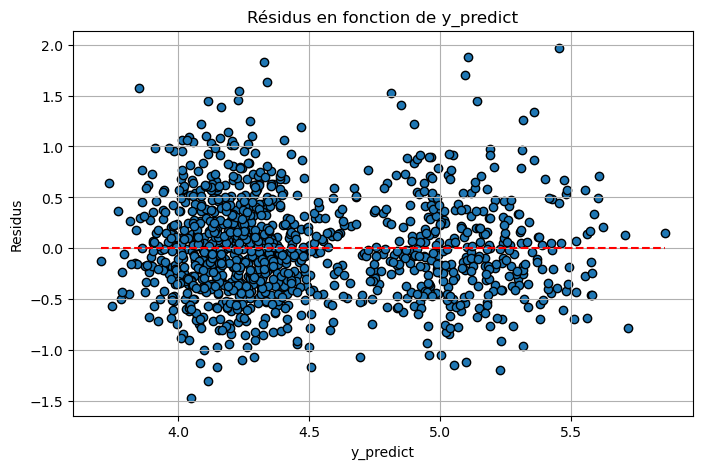

In [57]:
# Fitted vs. residuals
fitted_values = reg_multi.predict(X_train)
plt.figure(figsize=(8,5))
plt.scatter(x=fitted_values,y=reg_multi.resid , edgecolor='k')
xmin=min(fitted_values)
xmax = max(fitted_values)
plt.hlines(y=0,xmin=xmin,xmax=xmax,color='red',linestyle='--')

plt.xlabel("y_predict")
plt.ylabel("Residus")
plt.title("Résidus en fonction de y_predict")
plt.grid(True)
plt.show()

La distribution des résidus n'est pas homogène : 2 disques sont observés.

Il est également possible d’évaluer l'hypothèse d’homogénéité des résidus en employant le test de Breush-Pagan. L’hypothèse d’homogénéité est rejetée si la p-value est inférieure à 0.05

In [58]:
# Test de Breusch-Pagan - Homoscédacité des résidus
lagrande, pval, f, fpval = het_breuschpagan(reg_multi.resid, reg_multi.model.exog)
print("La p-value du Test de Breusch Pagan est ", pval)

La p-value du Test de Breusch Pagan est  8.821924115053341e-13


<div class="alert alert-block alert-warning">
L'hypothèse d'homogénéité des variances des résidus est rejettée.
    
*Note : un essai a été réalisé en transformant la variable cible au log (voir Notebook complet): ce test n'a pas été concluant, les résidus n'étaient pas homogènes.*
<div>

### 4.3. Atypicité et influence<a class="anchor" id="3_4_3"></a>

Les leviers et les résidus studentisés permettent d'évaluer l'atypicité des observations et la distance de Cook leur influence.
Les observations atypiques ET influentes pourront être retirées du jeu de données afin d'améliorer le modèle.

#### Leviers - atypicité sur les variables explicatives

In [59]:
alpha = 0.05
n = train.shape[0]
p = train.shape[1]

In [60]:
seuil_levier = 2*p/n

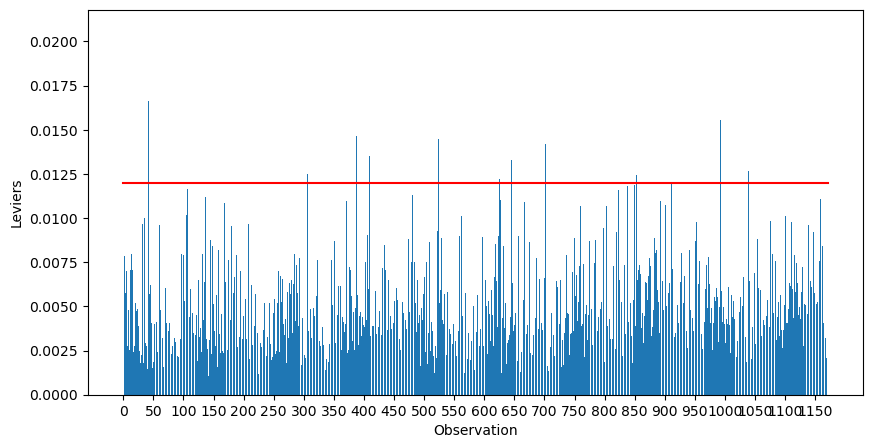

In [61]:
#Calcul de levier
analyses = pd.DataFrame({'obs':np.arange(1, n+1)})
analyses['levier'] = reg_multi.get_influence().hat_matrix_diag

plt.figure(figsize=(10,5))
plt.bar(analyses['obs'], analyses['levier'])
plt.xticks(np.arange(0, n, step=50))
plt.xlabel('Observation')
plt.ylabel('Leviers')
plt.plot([0, n+1], [seuil_levier, seuil_levier], color='r')
plt.show()

In [62]:
#Sélection des points pour lesquels le levier est supérieur au seuil
analyses.loc[analyses['levier'] > seuil_levier, :].shape

(26, 2)

In [63]:
levier_outliers = analyses.loc[analyses['levier'] > seuil_levier,'obs'].to_list()

#### Résidus studentisés internes - atypicité de la variable à expliquer
Le seuil pour les résidus studentisés est une loi de Student à n-p-1 degrés de liberté.

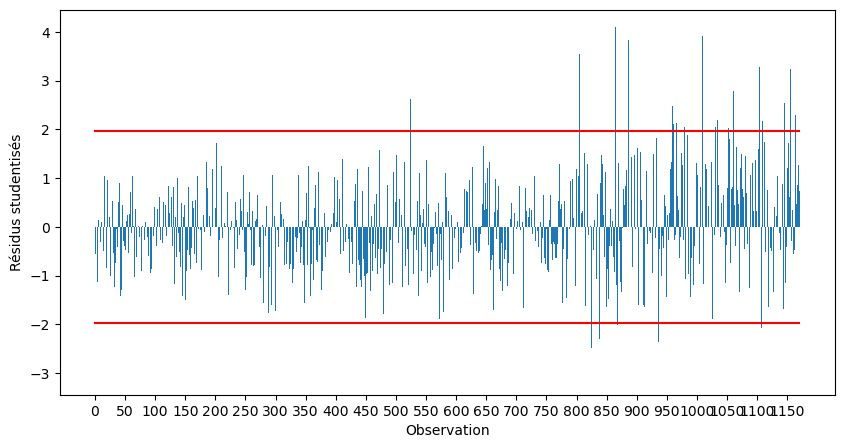

In [64]:
#Calculer les résidus studentisés
analyses['rstudent'] = reg_multi.get_influence().resid_studentized_internal
seuil_rstudent = st.t.ppf(1-alpha/2,n-p-1)
plt.figure(figsize=(10,5))
plt.bar(analyses['obs'], analyses['rstudent'])
plt.xticks(np.arange(0, n, step=50))
plt.xlabel('Observation')
plt.ylabel('Résidus studentisés')
plt.plot([0, n], [seuil_rstudent, seuil_rstudent], color='r')
plt.plot([0, n], [-seuil_rstudent, -seuil_rstudent], color='r')
plt.show()

In [65]:
#Sélection des points pour lesquels le résidu studentisé est supérieur au seuil_rstudent
analyses.loc[(analyses['rstudent'] > seuil_rstudent )| (analyses['rstudent'] < -seuil_rstudent) ].shape

(59, 3)

In [66]:
residus_studentises_outliers = \
    analyses.loc[(analyses['rstudent'] > seuil_rstudent )| (analyses['rstudent'] < -seuil_rstudent),'obs'].to_list()

#### Distance de Cook - Influence

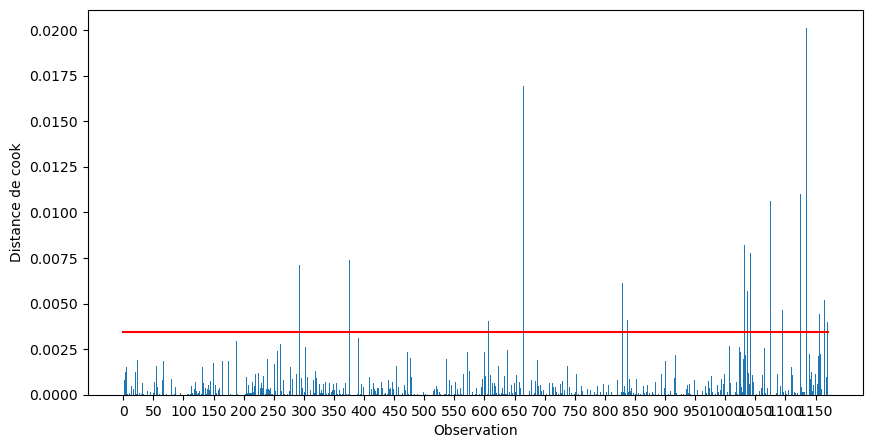

In [67]:
#Calcul de la distance de Cook
influence = reg_multi.get_influence().summary_frame()
analyses['dcooks'] = influence['cooks_d']
#Le seuil de la distance de Cook est de n-p.
seuil_dcook = 4/(n-p)
#détecter les observations influentes
plt.figure(figsize=(10,5))
plt.bar(analyses['obs'], analyses['dcooks'])
plt.xticks(np.arange(0, n, step=50))
plt.xlabel('Observation')
plt.ylabel('Distance de cook')
plt.plot([0, n], [seuil_dcook, seuil_dcook], color='r')
plt.show()

In [68]:
#Sélection des points pour lesquels La distance de Cook est supérieur au seuil de Cook
analyses.loc[analyses['dcooks'] > seuil_dcook, :].shape

(35, 4)

In [69]:
dcooks_outliers = analyses.loc[analyses['dcooks'] > seuil_dcook,'obs'].to_list()

#### En conclusion :

In [70]:
analyses.loc[(analyses.obs.isin(levier_outliers))&(analyses.obs.isin(dcooks_outliers))|
             (analyses.obs.isin(residus_studentises_outliers))& (analyses.obs.isin(dcooks_outliers))]

obs    levier  rstudent    dcooks
828    829  0.003131  2.212135  0.006110
837    838  0.011811 -2.307018  0.004101
965    966  0.004105  2.130535  0.012919
1036  1037  0.012866 -3.082180  0.005661
1060  1061  0.003334  2.789926  0.006761

5 observations ressortent comme atypiques et influentes.
<div class="alert alert-block alert-info">
Note : un essai a été réalisé en supprimant les valeurs atypiques et influentes (voir notebook complet). Cela n'a pas permis d'améliorer le modèle.
<div>

## <font color='green'>5. Imputation des valeurs manquantes<a class="anchor" id="3_5"></a></font>

<div class="alert alert-block alert-info">

Pour satisfaire les objectifs du projet, la régression linéaire multiple sera utilisée pour le remplacement des valeurs manquantes et ces données seront utilisées pour la suite du projet.     

<div>

In [71]:
# Utilisation du modèle de régression linéaire multiple pour imputer les valeurs manquantes
billets_mlr = billets.copy()
X_reg_multi = billets_mlr.loc[billets_mlr['margin_low'].isna(), \
                ['diagonal', 'height_left', 'height_right', 'margin_up', 'length']]
billets_mlr.loc[billets_mlr['margin_low'].isna(),'margin_low'] = reg_multi.predict(X_reg_multi)

In [72]:
# Nombre de valeurs manquantes après imputation
billets_mlr.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [73]:
# sauvegarde du fichier complet
billets_mlr.to_csv('billets_mlr.csv')

### Impact de l'imputation des valeurs manquantes 

In [74]:
# Comparaison moyenne, écart type et distribution
pd.DataFrame({'Billets'      : billets['margin_low'].describe(),
              'Billets_mlr'  : billets_mlr['margin_low'].describe()}).T

count      mean       std   min    25%   50%   75%  max
Billets      1463.0  4.485967  0.663813  2.98  4.015  4.31  4.87  6.9
Billets_mlr  1500.0  4.483595  0.659530  2.98  4.020  4.31  4.87  6.9

<div class="alert alert-block alert-info">
La moyenne et l'écart restent similaires après imputation des valeurs manquantes.
<div>

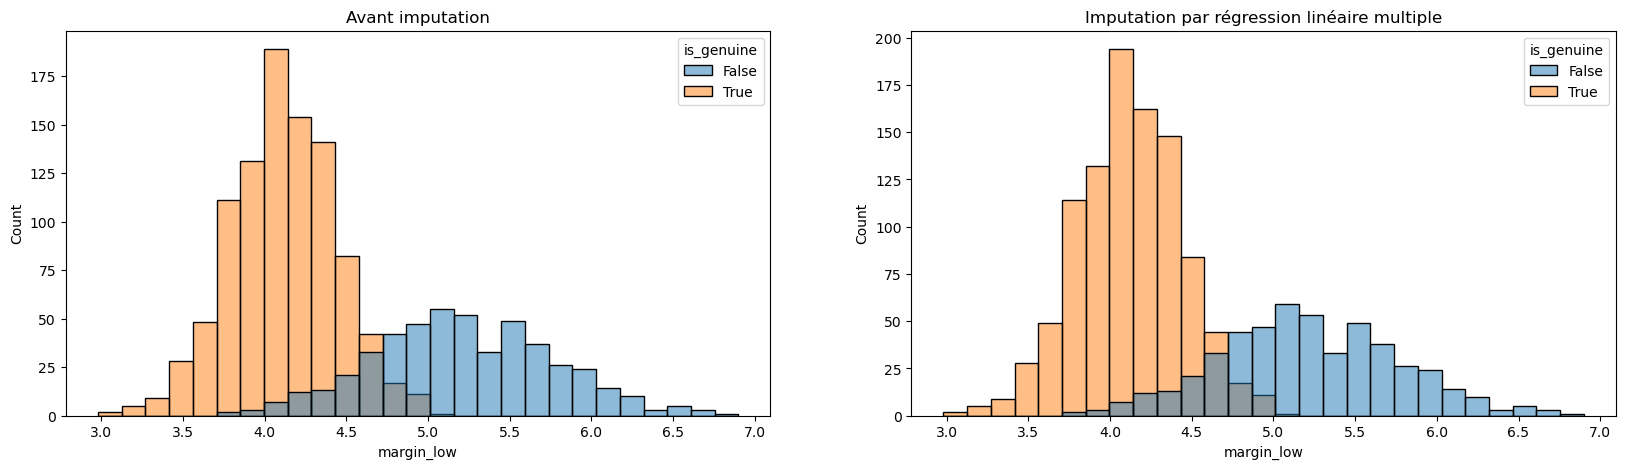

In [75]:
# Comparaison des distributions de 'margin_low' :
# avant imputation, imputation des valeurs manquantes par régression linéaire multiple
fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.histplot(data=billets, x='margin_low', hue='is_genuine', ax=ax[0])
ax[0].set_title('Avant imputation')

sns.histplot(data=billets_mlr, x='margin_low', hue='is_genuine', ax=ax[1])
ax[1].set_title('Imputation par régression linéaire multiple')
plt.show()

<div class="alert alert-block alert-info">
Nous observons que l'imputation des valeurs manquantes avec la régression linéaire multiple a très peu impacté la distribution des données.
<div>

# <font color='blue'>Partie 4 - Modèles de classification <a class="anchor" id="partie4"></a></font>

#### Démarche
L'objectif est de déterminer le modèle le plus performant possible pour identifier un maximum de faux billets au sein de la masse de billets analysés chaque jour.

* Algorithmes testés *( * voir Notebook complet)*:
    * Régression logistique
    * k-means
    * Décision tree (*)
    * Random forest
    * k-NN (*)
* L'influence de l'imputation des valeurs manquantes a également été analysée en comparant les résultats de l'imputation par la moyenne et par la régression linéaire multiple. *(voir Notebook complet)*

#### Evaluation des modèles

Les différentes mesures utilisées ici pour l'évaluation de la performance des algorithmes sont les suivantes : 

* Matrice de confusion :

|Matrice de confusion|Predict label : False|Predict label : True|
|--------------------|:------------------:|:-------------------:|
|**True Label : False**   |True Negative (TN)|False Positive (FP)  |
|**True Label : True**  |False Negative (FN) |True Positive (TP   |

* L'**accuracy** : ratio du nombre de prédictions correctes sur la taille de l'échantillon
$$Accuracy =  \frac{TP+TN}{TP+TN+FP+FN}$$
* La **sensibilité** : le taux d’individus positifs correctement prédits  = capacité du modèle à détecter l’ensemble des individus positifs
$$Sensibilité =  \frac{TP}{TP+FN}$$
* La **précision** : la proportion de prédictions correctes parmi les points que l’on a prédits positifs.
$$Précision =  \frac{TP}{TP+FP}$$
* La **spécificité** : le taux d’individus négatifs correctement prédits = capacité du modèle à détecter l’ensemble des individus négatifs
$$Spécificité =  \frac{TN}{TN+FP}$$
* Le **f score**:  moyenne harmonique de la précision et de la sensibilité
$$f score = 2×\frac{Précision×Sensibilité}{Précision+Sensibilité}=\frac{2TP}{2TP+FP+FN}$$
* Le **R2 score** : l’erreur du modèle divisé par l’erreur d’un modèle basique qui prédit tout le temps la moyenne de la variable à prédire Le score R2 est d’autant plus élevé que le modèle est performant, et vaut au maximum 100%, lorsque toutes les prédictions sont exactes.
* La courbe ROC (Receiver Operating Characteristic) représente la sensibilité en fonction de la spécificité pour différents seuils de décisions. L'aire sous la courbe ROC, l'**AUC** (Area Under the ROC), est une mesure de la qualité de la classification qui varie entre : 
    * AUC=1/2 : dans le pire des cas
    * AUC=1 : dans le meilleur des cas

## <font color='green'>1. Echantillons d'entraînement et de test<a class="anchor" id="4_1"></a></font> 

Pour que le modèle soit aussi bien entraîné à détecter les vrais et les faux billets, nous allons réaliser un échantillonnage stratifié. La variable utilisée pour la stratification est la variable 'is_genuine'.

In [76]:
X_mlr = billets_mlr[['diagonal', 'height_left', 'height_right','margin_low','margin_up', 'length']]
y_mlr = billets_mlr['is_genuine']

In [77]:
# Création de l'échantillon d'entraînement et de l'échantillon de test
# Stratify = répartition homogène de vrais et faux billets dans les échantillons des tests et entraînement
X_train_mlr, X_test_mlr, y_train_mlr, y_test_mlr = train_test_split(X_mlr, y_mlr, test_size=0.2, stratify=y_mlr, 
                                                                    random_state=42)

In [78]:
# vérification de la stratification
train_index = X_train_mlr.index.to_list()# récupération des index 
test_index = X_test_mlr.index.to_list()

print("Répartition vrais/faux billets dans les échantillons d'entraînement et de test")
train_prop = billets_mlr.loc[billets_mlr.index.isin(train_index),'is_genuine'].value_counts()/len(X_train_mlr)*100
print("Echantillon X_train : Size = %.f, True = %.1f, False = %.1f" % (X_train_mlr.shape[0], train_prop[0],train_prop[1]) )
test_prop = billets_mlr.loc[billets_mlr.index.isin(test_index),'is_genuine'].value_counts()/len(X_test_mlr)*100
print("Echantillon X_test : Size = %.f, True = %.1f, False = %.1f" % (X_test_mlr.shape[0], test_prop[0],test_prop[1]) )

Répartition vrais/faux billets dans les échantillons d'entraînement et de test
Echantillon X_train : Size = 1200, True = 66.7, False = 33.3
Echantillon X_test : Size = 300, True = 66.7, False = 33.3


In [79]:
# Standardisation des données
scaler = StandardScaler()
X_mlrs = scaler.fit_transform(X_mlr.values)
train_mlrs = scaler.fit_transform(X_train_mlr.values)
test_mlrs = scaler.fit_transform(X_test_mlr.values)

## <font color='green'>2. DummyClassifier - Référence de comparaison  <a class="anchor" id="4_2"></a></font> 
Nous utiliserons un dummy classifier, basé sur l'imputation de la valeur la plus fréquente, comme point de comparaison pour l'évaluation de nos modèles.

#### Entraînement du modèle

In [80]:
dum = DummyClassifier(strategy='most_frequent')

In [81]:
dum.fit(train_mlrs, y_train_mlr)

DummyClassifier(strategy='most_frequent')

#### Evaluation du modèle

In [82]:
y_pred_dum = dum.predict(test_mlrs)

In [83]:
# Dataframe avec les résultats de prédiction et les valeurs actuelles
pred_mlr_dum_df = pd.DataFrame({'actual':y_test_mlr, 'prediction':y_pred_dum})

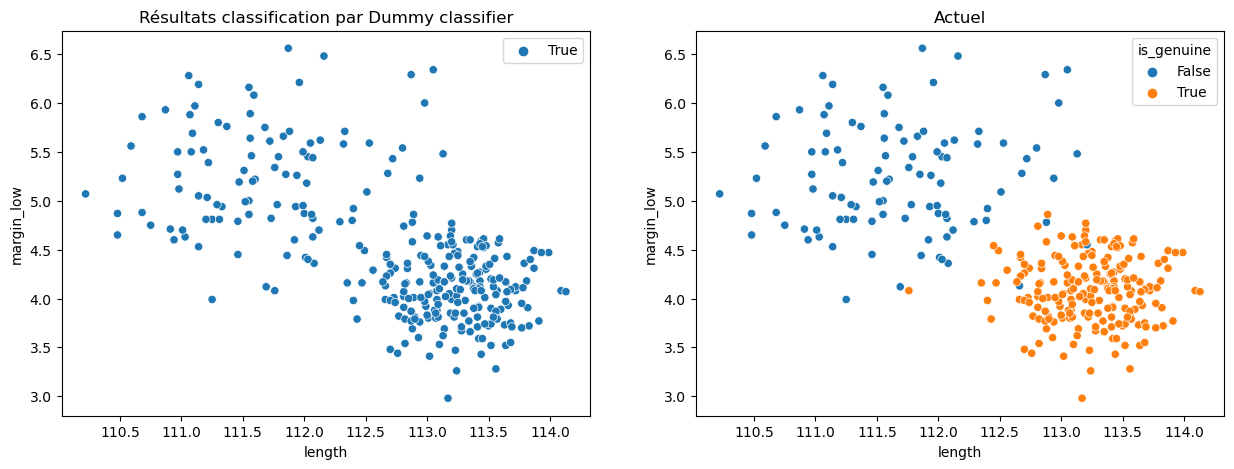

In [84]:
# Affichage des prédictions et actuels
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
sns.scatterplot(data=X_test_mlr, x='length', y='margin_low', hue=y_pred_dum, ax=ax1)
ax1.set_title('Résultats classification par Dummy classifier')
sns.scatterplot(data=X_test_mlr, x='length', y='margin_low', hue=y_test_mlr, ax=ax2)
ax2.set_title('Actuel')
plt.show()

##### Matrice de confusion

In [85]:
labels_cm = np.sort(billets.is_genuine.unique())

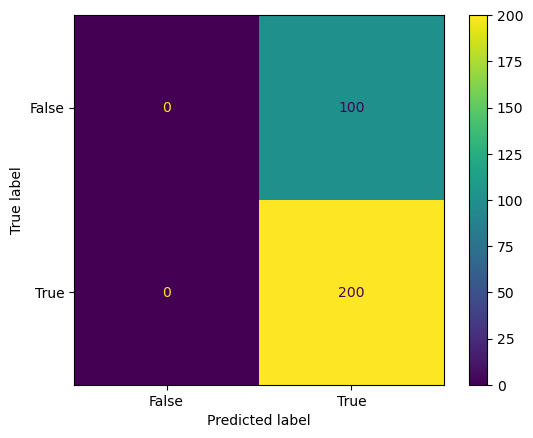

In [86]:
# Matrice de confusion
cm = confusion_matrix(y_test_mlr,y_pred_dum, labels=labels_cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_cm)
disp.plot()
plt.show()

##### Mesures d'évaluation du modèle

AUC for our classifier is: 0.5


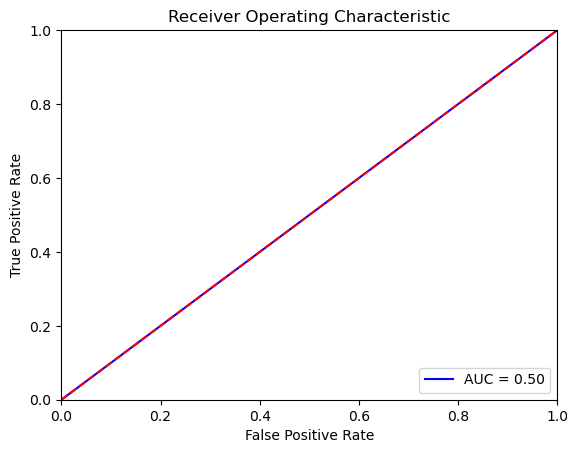

In [87]:
# Courbe ROC et AUC(Area Under the ROC)
fpr, tpr, threshold = roc_curve(y_test_mlr, y_pred_dum)
roc_auc = auc(fpr, tpr)

# Printing AUC
print(f"AUC for our classifier is: {roc_auc}")

# Plotting the ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [88]:
from sklearn.metrics import f1_score, r2_score

In [89]:
# récupération des valeurs de la matrice de confusion pour le calcul du score de spécificité
tn, fp, fn, tp = cm.ravel()

In [90]:
accuracy = round(accuracy_score(y_test_mlr,y_pred_dum),3)
precision = round(precision_score(y_test_mlr,y_pred_dum),3)
sensibilite = round(recall_score(y_test_mlr,y_pred_dum),3)
specificite = round(tn/(tn+fp),3)
f1_score = round(f1_score(y_test_mlr,y_pred_dum),3)
r2_score = round(r2_score(y_test_mlr.astype(int),y_pred_dum.astype(int)),3)

In [91]:
eval_dum_mlr_df = pd.DataFrame({'Modèle': ['Dummy Classifier'],
                                   'Imputation NaN' : ['Régression linéaire multiple'],
                                   'Accuracy' :accuracy,
                                   'Précision' : precision,
                                   'Sensibilité' : sensibilite,
                                   'Spécificité': specificite,                               
                                   'f1_score' : f1_score,
                                   'R2 score': r2_score,
                                   'AUC' : roc_auc })
eval_dum_mlr_df

Modèle                Imputation NaN  Accuracy  Précision  \
0  Dummy Classifier  Régression linéaire multiple     0.667      0.667   

   Sensibilité  Spécificité  f1_score  R2 score  AUC  
0          1.0          0.0       0.8      -0.5  0.5

## <font color='green'>3. Régression logistique<a class="anchor" id="4_3"></a></font> 

### Variables significatives

In [92]:
data = billets_mlr
reg_log = smf.glm('is_genuine~diagonal+height_left+height_right+margin_low+margin_up+length',
                   data=data, family=sm.families.Binomial()).fit()
print(reg_log.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1500
Model:                                                   GLM   Df Residuals:                     1493
Model Family:                                       Binomial   Df Model:                            6
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -42.387
Date:                                       Sun, 06 Aug 2023   Deviance:                       84.775
Time:                                               18:51:09   Pearson chi2:                 2.66e+03
No. Iterations:                                           10   Pseudo R-squ. (CS):             0.7037
Covariance Type:                                   nonrobust                      

* La variable 'diagonal' a la p-value la plus élevée et > 0.05 : retirons-la et retestons.

In [93]:
data = billets_mlr[['is_genuine', 'height_left', 'height_right', 'margin_up', 'length', 'margin_low']]
reg_log = smf.glm('is_genuine~height_left+height_right+margin_low+margin_up+length',
                   data=data, family=sm.families.Binomial()).fit()
print(reg_log.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1500
Model:                                                   GLM   Df Residuals:                     1494
Model Family:                                       Binomial   Df Model:                            5
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -42.389
Date:                                       Sun, 06 Aug 2023   Deviance:                       84.779
Time:                                               18:51:09   Pearson chi2:                 2.66e+03
No. Iterations:                                           10   Pseudo R-squ. (CS):             0.7037
Covariance Type:                                   nonrobust                      

* La variable 'height_left' a la p-value la plus élevée et > 0.05 : retirons-la et retestons.

In [94]:
data = billets[['is_genuine', 'height_right', 'margin_up', 'length', 'margin_low']]
reg_log = smf.glm('is_genuine~height_right+margin_low+margin_up+length',
                   data=data, family=sm.families.Binomial()).fit()
print(reg_log.summary())

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1463
Model:                                                   GLM   Df Residuals:                     1458
Model Family:                                       Binomial   Df Model:                            4
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -39.777
Date:                                       Sun, 06 Aug 2023   Deviance:                       79.555
Time:                                               18:51:09   Pearson chi2:                 3.00e+03
No. Iterations:                                           10   Pseudo R-squ. (CS):             0.7056
Covariance Type:                                   nonrobust                      

Les variables significatives sont : 'height_right','margin_low', 'margin_up' et 'length' avec une p-value < 0.05.

In [95]:
# Sélection des variables
X_train_mlrs = train_mlrs[:,2:]
X_test_mlrs = test_mlrs[:,2:]

### Sélection du modèle
Pour sélectionner le meilleur modèle de régression logistique, nous allons utiliser la fonction GridSearchCV() de scikit-learn.
Le score à optimiser est la précision : 

In [96]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = {'penalty': [None,'l2'],
              'solver': ['lbfgs', 'newton-cg', 'newton-cholesky','sag','saga']}

# Fixer le score à optimiser
score = 'accuracy'

In [97]:
# Créer un modèle de LogisticRegression avec recherche d'hyperparamètre par validation croisée
grid_search = GridSearchCV(
    LogisticRegression(), # un modèle de régression logistique
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
)

In [98]:
# Optimiser ce modèle sur le jeu d'entraînement
grid_search.fit(X_train_mlrs, y_train_mlr)

C:\Users\Adeline\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge

C:\Users\Adeline\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning:

The max_iter was reached which means the coef_ did not converge



GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'penalty': [None, 'l2'],
                         'solver': ['lbfgs', 'newton-cg', 'newton-cholesky',
                                    'sag', 'saga']},
             scoring='accuracy')

In [99]:
print(grid_search.best_params_)
# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        grid_search.cv_results_['mean_test_score'], # score moyen
        grid_search.cv_results_['std_test_score'],  # écart-type du score
        grid_search.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )

{'penalty': None, 'solver': 'lbfgs'}
Résultats de la validation croisée :
accuracy = 0.990 (+/-0.012) for {'penalty': None, 'solver': 'lbfgs'}
accuracy = 0.990 (+/-0.012) for {'penalty': None, 'solver': 'newton-cg'}
accuracy = 0.990 (+/-0.012) for {'penalty': None, 'solver': 'newton-cholesky'}
accuracy = 0.990 (+/-0.012) for {'penalty': None, 'solver': 'sag'}
accuracy = 0.990 (+/-0.012) for {'penalty': None, 'solver': 'saga'}
accuracy = 0.990 (+/-0.014) for {'penalty': 'l2', 'solver': 'lbfgs'}
accuracy = 0.990 (+/-0.014) for {'penalty': 'l2', 'solver': 'newton-cg'}
accuracy = 0.990 (+/-0.014) for {'penalty': 'l2', 'solver': 'newton-cholesky'}
accuracy = 0.990 (+/-0.014) for {'penalty': 'l2', 'solver': 'sag'}
accuracy = 0.990 (+/-0.014) for {'penalty': 'l2', 'solver': 'saga'}


### Entraînement du modèle

In [100]:
# Instanciation et entraînement du modèle de régression logistique
reg_log2 = LogisticRegression(penalty=None,solver='lbfgs',random_state=42)
reg_log2.fit(X_train_mlrs,y_train_mlr)

LogisticRegression(penalty=None, random_state=42)

In [101]:
pd.DataFrame(np.concatenate([reg_log2.intercept_.reshape(-1,1),
                             reg_log2.coef_],axis=1),
             index = ["coef"],
             columns = ["constante"]+list(X_train_mlr.columns[2:])).T

coef
constante     1.953823
height_right -0.786387
margin_low   -3.839482
margin_up    -2.307614
length        5.515005

### Cross-validation

In [102]:
from sklearn.model_selection import cross_val_score

In [103]:
score = cross_val_score(LogisticRegression(penalty=None,solver='lbfgs',random_state= 42), 
                        train_mlrs, 
                        y_train_mlr, 
                        cv= 5, 
                        scoring="accuracy"
                       )
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')

Scores for each fold are: [0.99583333 0.9875     0.98333333 0.97916667 0.99583333]
Average score: 0.99


### Evaluation du modèle

In [104]:
pred_mlr_log = reg_log2.predict(X_test_mlrs)

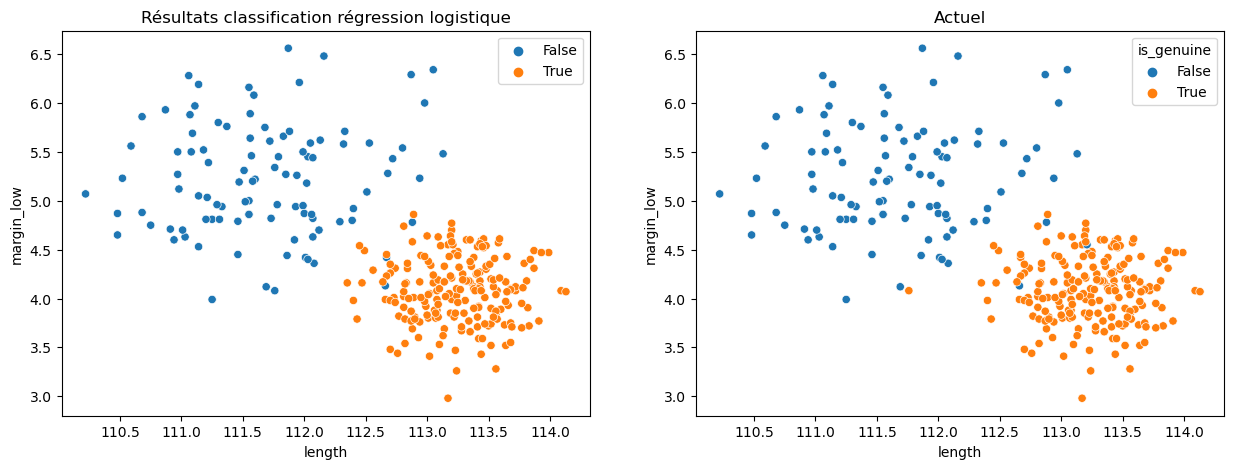

In [105]:
# Affichage des prédictions et actuels
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
sns.scatterplot(data=X_test_mlr, x='length', y='margin_low', hue=pred_mlr_log, ax=ax1)
ax1.set_title('Résultats classification régression logistique')
sns.scatterplot(data=X_test_mlr, x='length', y='margin_low', hue=y_test_mlr, ax=ax2)
ax2.set_title('Actuel')
plt.show()

#### Matrice de confusion

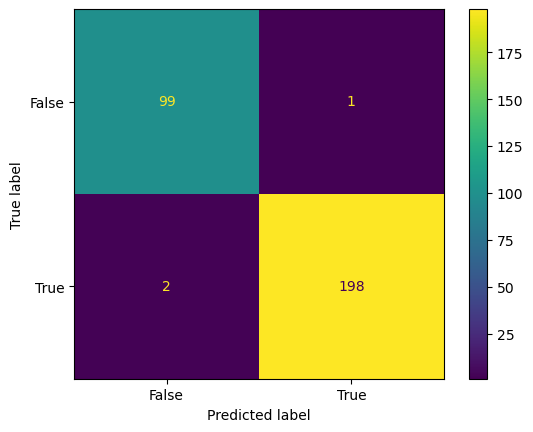

In [106]:
# Matrice de confusion
cm = confusion_matrix(y_test_mlr,pred_mlr_log, labels=labels_cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_cm)
disp.plot()
plt.show()

#### Mesures d'évaluation du modèle

AUC for our classifier is: 0.99


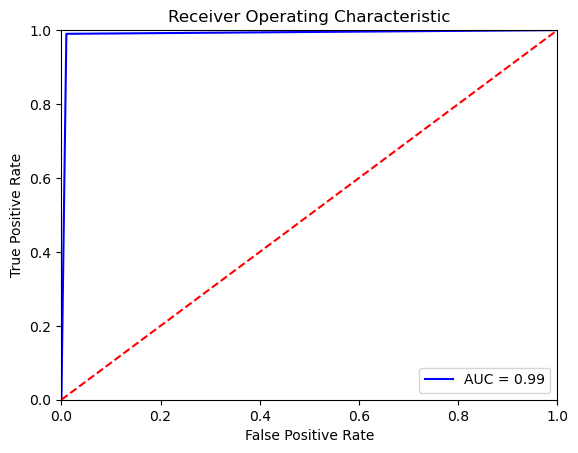

In [107]:
# Courbe ROC et AUC(Area Under the ROC)
fpr, tpr, threshold = roc_curve(y_test_mlr, pred_mlr_log)
roc_auc = auc(fpr, tpr)

# Printing AUC
print(f"AUC for our classifier is: {roc_auc}")

# Plotting the ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [108]:
from sklearn.metrics import f1_score, r2_score

In [109]:
# récupération des valeurs de la matrice de confusion pour le calcul du score de spécificité
tn, fp, fn, tp = cm.ravel()

In [110]:
accuracy = round(accuracy_score(y_test_mlr,pred_mlr_log),3)
precision = round(precision_score(y_test_mlr,pred_mlr_log),3)
sensibilite = round(recall_score(y_test_mlr,pred_mlr_log),3)
specificite = round(tn/(tn+fp),3)
f1_score = round(f1_score(y_test_mlr,pred_mlr_log),3)
r2_score = round(r2_score(y_test_mlr.astype(int),pred_mlr_log.astype(int)),3)

In [111]:
eval_log_mlrs_df = pd.DataFrame({'Modèle': ['Régression logistique'],
                                   'Imputation NaN' : ['Régression linéaire multiple'],
                                   'Accuracy' :accuracy,
                                   'Précision' : precision,
                                   'Sensibilité' : sensibilite,
                                   'Spécificité': specificite,                               
                                   'f1_score' : f1_score,
                                   'R2 score': r2_score,
                                   'AUC' : roc_auc })
eval_log_mlrs_df

Modèle                Imputation NaN  Accuracy  Précision  \
0  Régression logistique  Régression linéaire multiple      0.99      0.995   

   Sensibilité  Spécificité  f1_score  R2 score   AUC  
0         0.99         0.99     0.992     0.955  0.99

### Amélioration du modèle - calcul du seuil optimal

Pour améliorer le modèle de régression logistique, nous pouvons analyser les résultats en fonction de différents seuils de probabilité (threshold). Pour défaut, le seuil est fixé à 0.5, c'est-à-dire que si la probabilité d'être vrai est >= à 0.5, le billet est classé vrai sinon il est classé faux.

##### Détermination du seuil optimal

In [112]:
# Probabilité d'être classé "vrai"
class_prob = reg_log2.predict_proba(X_test_mlrs)[:, 1]

# Listes vides
thresholds =[]
accuracy = []
precision = []
sensibilite = []
specificite = []
f1_score = []
AUC = []


# Itération sur différents seuils
for p in np.arange(0.1, 1, 0.1):
    thresholds.append(p)
    # Prédiction sur les données de test avec le seuil courant
    y_pred_log = (class_prob >= p)
    # Calcul des mesures de performance avec le seuil courant
    cm = confusion_matrix(y_test_mlr,y_pred_log)
    tn, fp, fn, tp = cm.ravel()
    fpr, tpr, threshold = roc_curve(y_test_mlr, y_pred_log)
    roc_auc = auc(fpr, tpr)
    AUC.append(roc_auc)
    accuracy.append((tp+tn)/(tp+tn+fp+fn))
    precision.append(tp/(tp+fp))
    sensibilite.append(tp/(tp+fn))
    specificite.append(tn/(tn+fp))
    f1_score.append(2*tp/(2*tp+fp+fn))

# Dataframe avec les résultats pour différents thresholds    
threshold_df = pd.DataFrame({'thresholds':thresholds,
                             'accuracy' : accuracy,
                             'precision': precision,
                             'sensibilite':sensibilite,
                             'specificite':specificite,
                             'f1-score':f1_score,
                             'AUC': AUC
                            })
threshold_df

thresholds  accuracy  precision  sensibilite  specificite  f1-score     AUC
0         0.1  0.990000   0.990050        0.995         0.98  0.992519  0.9875
1         0.2  0.990000   0.990050        0.995         0.98  0.992519  0.9875
2         0.3  0.990000   0.990050        0.995         0.98  0.992519  0.9875
3         0.4  0.990000   0.990050        0.995         0.98  0.992519  0.9875
4         0.5  0.990000   0.994975        0.990         0.99  0.992481  0.9900
5         0.6  0.990000   1.000000        0.985         1.00  0.992443  0.9925
6         0.7  0.983333   1.000000        0.975         1.00  0.987342  0.9875
7         0.8  0.966667   1.000000        0.950         1.00  0.974359  0.9750
8         0.9  0.956667   1.000000        0.935         1.00  0.966408  0.9675

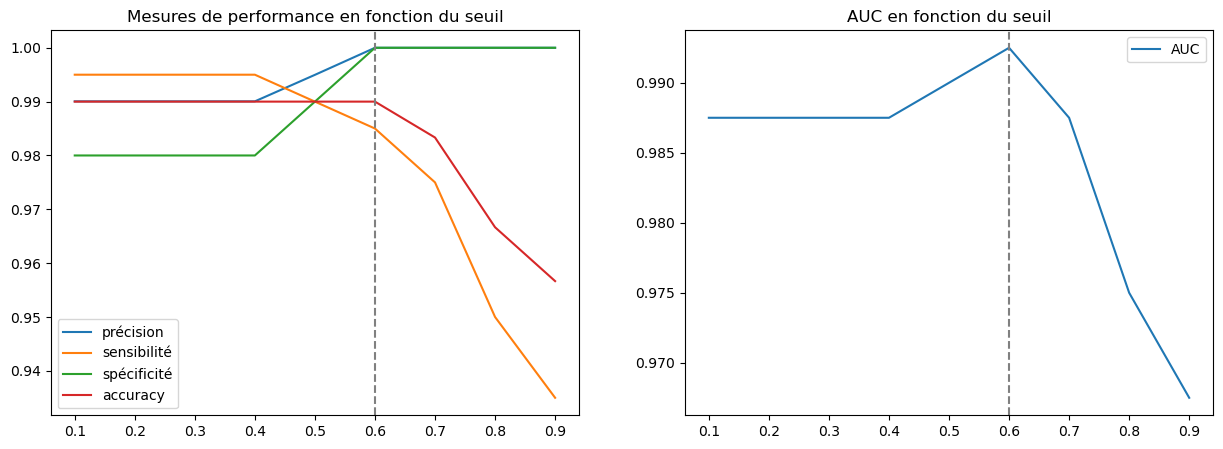

In [113]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
sns.lineplot(data=threshold_df, x=thresholds, y=precision, label='précision', ax=ax1)
sns.lineplot(data=threshold_df, x=thresholds, y=sensibilite, label="sensibilité", ax=ax1)
sns.lineplot(data=threshold_df, x=thresholds, y=specificite, label="spécificité", ax=ax1)
sns.lineplot(data=threshold_df, x=thresholds, y=accuracy, label="accuracy", ax=ax1)
ax1.axvline(x = 0.6, color = "gray", linestyle='--') 
ax1.set_title('Mesures de performance en fonction du seuil')
sns.lineplot(data=threshold_df, x=thresholds, y=AUC, label="AUC", ax=ax2)
ax2.axvline(x = 0.6, color = "gray", linestyle='--') 
ax2.set_title('AUC en fonction du seuil')
plt.show()

<div class="alert alert-block alert-info">
Dans notre cas, l'optimum est atteint lorsque le modèle a la meilleure proportion de prédiction correcte pour les billets prédis comme vrai, précision, et qu'il est le plus performant à attribuer la bonne classe, AUC. Ici, l'optimum est atteint pour le score le plus haut d'AUC.
<div>

In [114]:
# Définition du seuil optimal
threshold_optim = threshold_df.thresholds[np.argmax(threshold_df.AUC)]
print("Le seuil optimal est threshold_optimal est ", threshold_optim)

# Classification en fonction du seuil
y_pred_mlr_optim = (class_prob >= threshold_optim)

Le seuil optimal est threshold_optimal est  0.6


##### Matrice de confusion

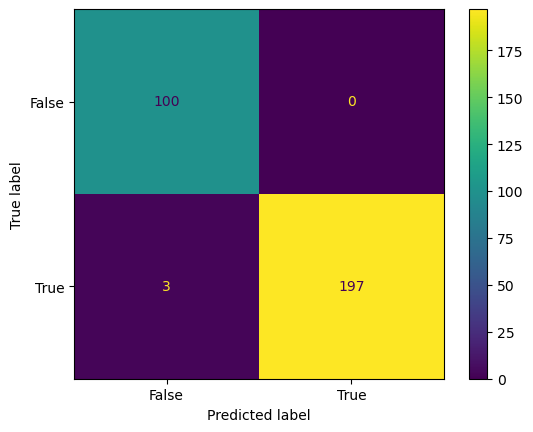

In [115]:
# Matrice de confusion
cm = confusion_matrix(y_test_mlr,y_pred_mlr_optim, labels=labels_cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_cm)
disp.plot()
plt.show()

##### Mesures d'évaluation du modèle

AUC for our classifier is: 0.9924999999999999


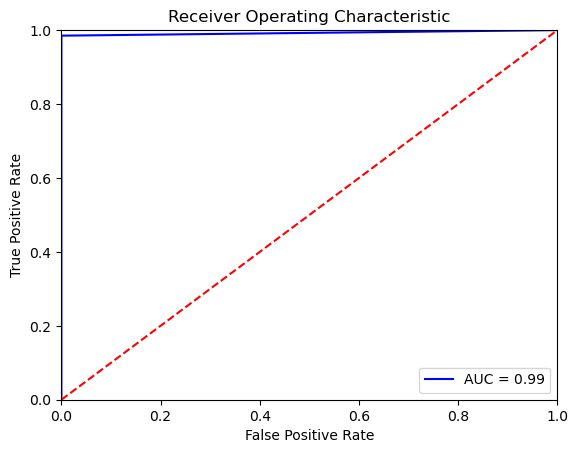

In [116]:
# Courbe ROC et AUC(Area Under the ROC)
fpr, tpr, threshold = roc_curve(y_test_mlr, y_pred_mlr_optim)
roc_auc = auc(fpr, tpr)

# Printing AUC
print(f"AUC for our classifier is: {roc_auc}")

# Plotting the ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [117]:
from sklearn.metrics import f1_score, r2_score

In [118]:
# récupération des valeurs de la matrice de confusion pour le calcul du score de spécificité
tn, fp, fn, tp = cm.ravel()

accuracy = round(accuracy_score(y_test_mlr,y_pred_mlr_optim),3)
precision = round(precision_score(y_test_mlr,y_pred_mlr_optim),3)
sensibilite = round(recall_score(y_test_mlr,y_pred_mlr_optim),3)
specificite = round(tn/(tn+fp),3)
f1_score = round(f1_score(y_test_mlr,y_pred_mlr_optim),3)
r2_score = round(r2_score(y_test_mlr.astype(int),y_pred_mlr_optim.astype(int)),3)

In [119]:
eval_log_optim_df = pd.DataFrame({'Modèle': ['Régression logistique - seuil = 0.6'],
                                   'Imputation NaN' : ['Régression linéaire multiple'],
                                   'Accuracy' :accuracy,
                                   'Précision' : precision,
                                   'Sensibilité' : sensibilite,
                                   'Spécificité': specificite,                               
                                   'f1_score' : f1_score,
                                   'R2 score': r2_score,
                                   'AUC' : roc_auc })
eval_log_optim_df

Modèle                Imputation NaN  \
0  Régression logistique - seuil = 0.6  Régression linéaire multiple   

   Accuracy  Précision  Sensibilité  Spécificité  f1_score  R2 score     AUC  
0      0.99        1.0        0.985          1.0     0.992     0.955  0.9925

## <font color='green'>4. Clustering k-means<a class="anchor" id="4_4"></a></font> 

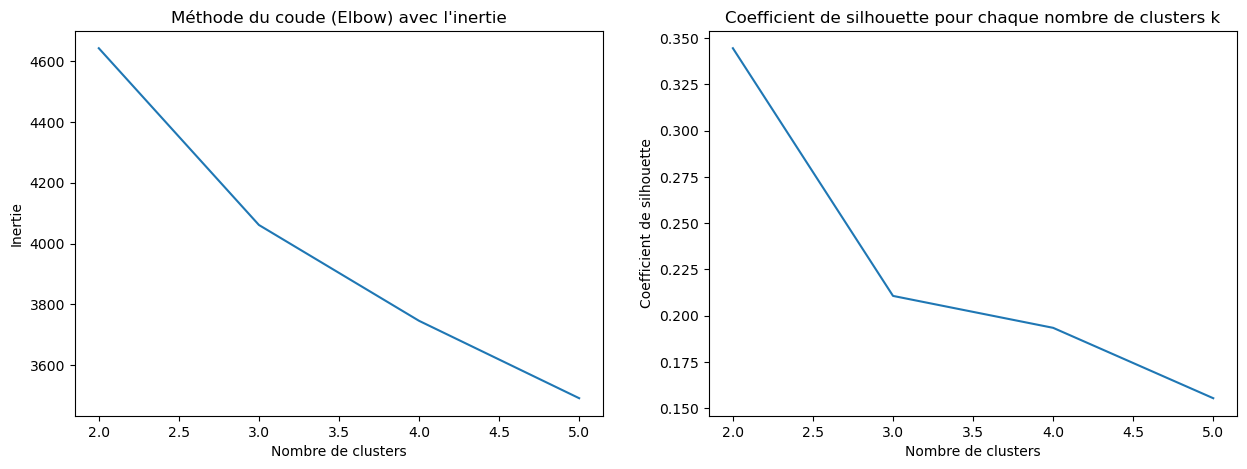

In [120]:
inertia_scores = []
silhouette_scores = []
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))

for k in range(2, 6):
    kmeans = KMeans(n_clusters=k,n_init=10, init='k-means++',random_state=24)
    kmeans.fit(train_mlrs)
    labels = kmeans.labels_
    inertia_scores.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(train_mlrs, labels))

ax1.plot(range(2, 6), inertia_scores)
ax1.set_title("Méthode du coude (Elbow) avec l'inertie")
ax1.set_xlabel('Nombre de clusters')
ax1.set_ylabel('Inertie')

ax2.plot(range(2, 6), silhouette_scores)
ax2.set_title('Coefficient de silhouette pour chaque nombre de clusters k')
ax2.set_xlabel('Nombre de clusters')
ax2.set_ylabel('Coefficient de silhouette')
plt.show()

Nous choisissons k=2 clusters : un vrai billet, un faux billet.
Le silhouette score est également plus élevé pour 2 clusters

In [121]:
# Nombre de clusters
k = 2

### Entraînement du modèle

In [122]:
# Instanciation et entraînement du modèle k-means
kmeans_mlr = KMeans(n_clusters=k, n_init=1, init='k-means++', random_state=42)
kmeans_mlr.fit(train_mlrs)

# Stockage des clusters dans la variable labels
labels_mlr = kmeans_mlr.labels_

In [123]:
# Centroïdes
X_train_mlr['cluster_kmeans']=labels_mlr
centroids_mlr = X_train_mlr.groupby('cluster_kmeans').mean()
X_train_mlr = X_train_mlr.drop('cluster_kmeans',axis=1)

In [124]:
# Dataframe avec les résultats du kmeans et les valeurs actuelles
train_mlr_kmeans_df = pd.DataFrame({'actual':y_train_mlr, 'cluster_kmeans':labels_mlr})
train_mlr_kmeans_df['cluster_kmeans'] = train_mlr_kmeans_df['cluster_kmeans'].replace([1,0],[False,True])

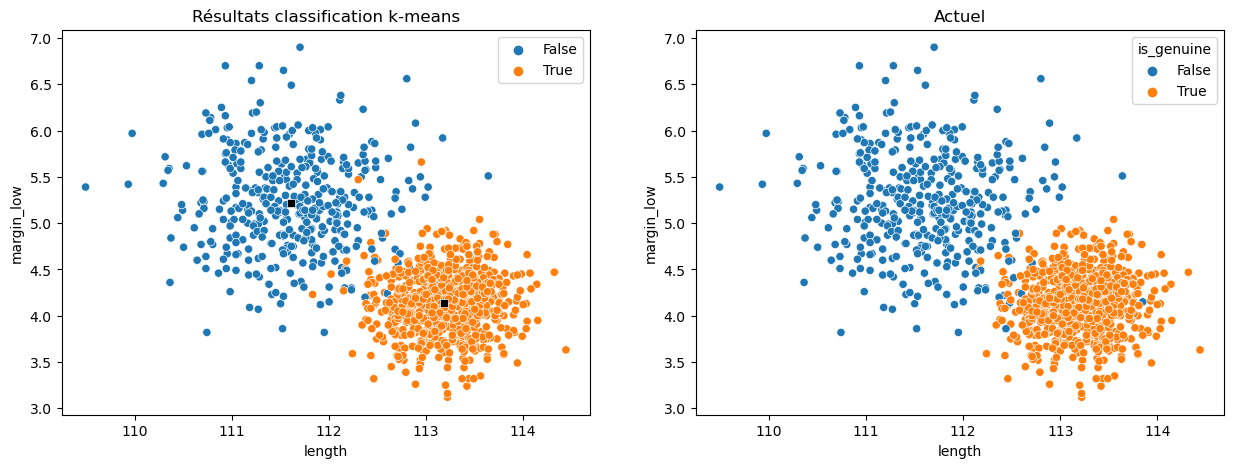

In [125]:
# Affichage des clusters
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
sns.scatterplot(data=X_train_mlr, x='length', y='margin_low', hue=train_mlr_kmeans_df['cluster_kmeans'], ax=ax1)
sns.scatterplot(data=centroids_mlr, x='length', y='margin_low',  marker="s", c="black", ax=ax1)# centroïdes
ax1.set_title('Résultats classification k-means')
sns.scatterplot(data=X_train_mlr, x='length', y='margin_low', hue=y_train_mlr, ax=ax2)
ax2.set_title('Actuel')
plt.show()

### Evaluation du modèle

In [126]:
pred_mlr_kmeans = kmeans_mlr.predict(test_mlrs)

In [127]:
# Dataframe avec les résultats de prédiction et les valeurs actuelles
pred_mlr_kmeans_df = pd.DataFrame({'actual':y_test_mlr, 'prediction':pred_mlr_kmeans})
pred_mlr_kmeans_df['prediction'] = pred_mlr_kmeans_df['prediction'].replace([1,0],[False,True])

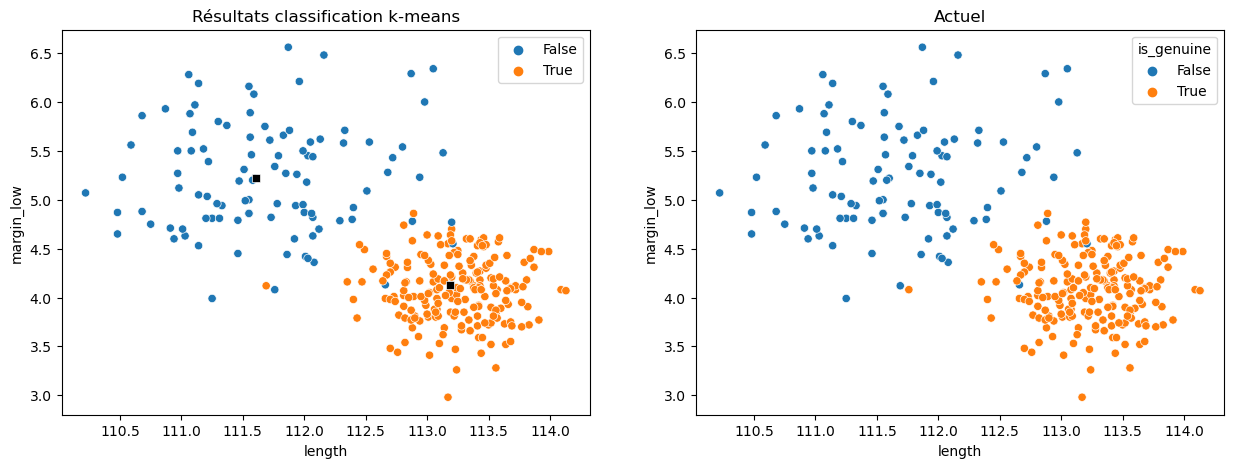

In [128]:
# Affichage des clusters
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
sns.scatterplot(data=X_test_mlr, x='length', y='margin_low', hue=pred_mlr_kmeans_df['prediction'], ax=ax1)
sns.scatterplot(data=centroids_mlr, x='length', y='margin_low',  marker="s", c="black", ax=ax1)# centroïdes
ax1.set_title('Résultats classification k-means')
sns.scatterplot(data=X_test_mlr, x='length', y='margin_low', hue=y_test_mlr, ax=ax2)
ax2.set_title('Actuel')
plt.show()

#### Matrice de confusion

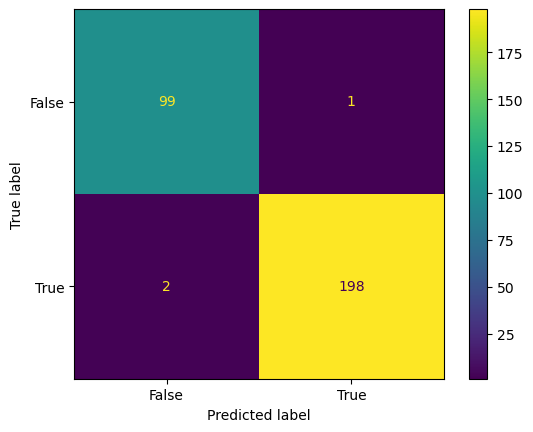

In [129]:
# Matrice de confusion
cm = confusion_matrix(pred_mlr_kmeans_df.actual,pred_mlr_kmeans_df.prediction, labels=labels_cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_cm)
disp.plot()
plt.show()

#### Mesures d'évaluation du modèle

AUC for our classifier is: 0.99


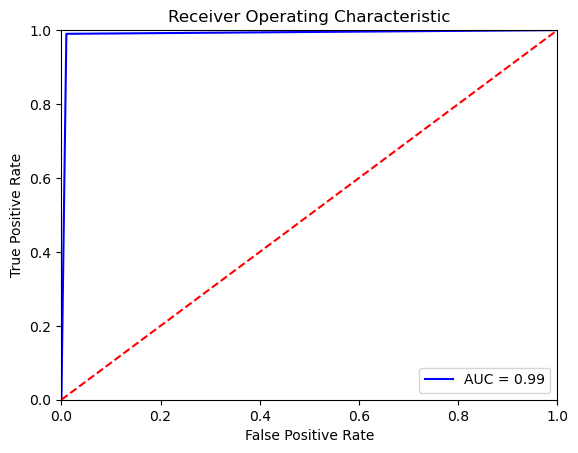

In [130]:
# Courbe ROC et AUC(Area Under the ROC)
fpr, tpr, threshold = roc_curve(pred_mlr_kmeans_df.actual,pred_mlr_kmeans_df.prediction)
roc_auc = auc(fpr, tpr)

# Printing AUC
print(f"AUC for our classifier is: {roc_auc}")

# Plotting the ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [131]:
from sklearn.metrics import f1_score, r2_score

In [132]:
# récupération des valeurs de la matrice de confusion pour le calcul du score de spécificité
tn, fp, fn, tp = cm.ravel()

In [133]:
accuracy = round(accuracy_score(pred_mlr_kmeans_df.actual,pred_mlr_kmeans_df.prediction),3)
precision = round(precision_score(pred_mlr_kmeans_df.actual,pred_mlr_kmeans_df.prediction),3)
sensibilite = round(recall_score(pred_mlr_kmeans_df.actual,pred_mlr_kmeans_df.prediction),3)
specificite = round(tn/(tn+fp),3)
f1_score = round(f1_score(pred_mlr_kmeans_df.actual,pred_mlr_kmeans_df.prediction),3)
r2_score = round(r2_score(pred_mlr_kmeans_df.actual.astype(int),pred_mlr_kmeans_df.prediction.astype(int)),3)

In [134]:
eval_kmeans_mlr_df = pd.DataFrame({'Modèle': ['k-means'],
                                   'Imputation NaN' : ['Régression linéaire mulitiple'],
                                   'Accuracy' :accuracy,
                                   'Précision' : precision,
                                   'Sensibilité' : sensibilite,
                                   'Spécificité': specificite,                                      
                                   'f1_score' : f1_score,
                                   'R2 score': r2_score,
                                   'AUC' :roc_auc})
eval_kmeans_mlr_df

Modèle                 Imputation NaN  Accuracy  Précision  Sensibilité  \
0  k-means  Régression linéaire mulitiple      0.99      0.995         0.99   

   Spécificité  f1_score  R2 score   AUC  
0         0.99     0.992     0.955  0.99

## <font color='green'>5. Random forest<a class="anchor" id="4_5"></a></font> 

Random forest est une méthode d'ensemble : elle combine les résultats de plusieurs arbres de décision pour obtenir le résultat final. pour le Random forest de classification,  l'estimation finale consiste à choisir la catégorie de réponse la plus fréquente. 

### Sélection du modèle
Pour sélectionner le meilleur modèle de régression logistique, nous allons utiliser la fonction GridSearchCV() de scikit-learn.
Le score à optimiser est la précision : 

In [135]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = { 
    'max_features': ['sqrt', 'log2'],
    'criterion' :['gini', 'entropy']
}

# Fixer le score à optimiser
score = 'accuracy'

In [136]:
# Créer un modèle de LogisticRegression avec recherche d'hyperparamètre par validation croisée
grid_search = GridSearchCV(
    RandomForestClassifier(random_state = 42), # un modèle de régression logistique
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
)

In [137]:
# Optimiser ce modèle sur le jeu d'entraînement
grid_search.fit(X_train_mlrs, y_train_mlr)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['sqrt', 'log2']},
             scoring='accuracy')

In [138]:
print(grid_search.best_params_)
# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        grid_search.cv_results_['mean_test_score'], # score moyen
        grid_search.cv_results_['std_test_score'],  # écart-type du score
        grid_search.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )

{'criterion': 'entropy', 'max_features': 'sqrt'}
Résultats de la validation croisée :
accuracy = 0.989 (+/-0.010) for {'criterion': 'gini', 'max_features': 'sqrt'}
accuracy = 0.989 (+/-0.010) for {'criterion': 'gini', 'max_features': 'log2'}
accuracy = 0.990 (+/-0.008) for {'criterion': 'entropy', 'max_features': 'sqrt'}
accuracy = 0.990 (+/-0.008) for {'criterion': 'entropy', 'max_features': 'log2'}


### Entraînement du modèle

In [139]:
rf_mlr = RandomForestClassifier(criterion='entropy', max_features='sqrt', random_state=42)

In [140]:
rf_mlr.fit(train_mlrs,y_train_mlr)

RandomForestClassifier(criterion='entropy', random_state=42)

In [141]:
# importance des variables dans le modèle d'arbre de décision
pd.DataFrame(rf_mlr.feature_importances_,
              index = X_train_mlr.columns, 
              columns = ["importance"]).sort_values(
     "importance", 
     ascending = False)

importance
length          0.490480
margin_low      0.313957
margin_up       0.100950
height_right    0.044458
height_left     0.040434
diagonal        0.009722

### Evaluation du modèle

In [142]:
pred_mlr_rf = rf_mlr.predict(test_mlrs)

In [143]:
# Dataframe avec les résultats de prédiction et les valeurs actuelles
pred_mlr_rf_df = pd.DataFrame({'actual':y_test_mlr, 'prediction':pred_mlr_rf})

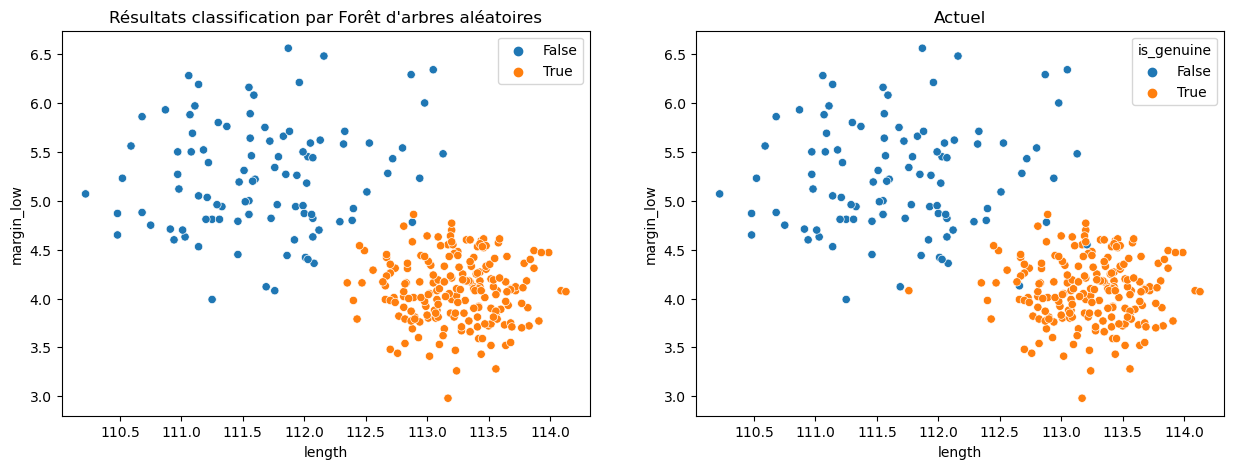

In [144]:
# Affichage des prédictions et actuels
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
sns.scatterplot(data=X_test_mlr, x='length', y='margin_low', hue=pred_mlr_rf, ax=ax1)
ax1.set_title("Résultats classification par Forêt d'arbres aléatoires")
sns.scatterplot(data=X_test_mlr, x='length', y='margin_low', hue=y_test_mlr, ax=ax2)
ax2.set_title('Actuel')
plt.show()

#### Matrice de confusion

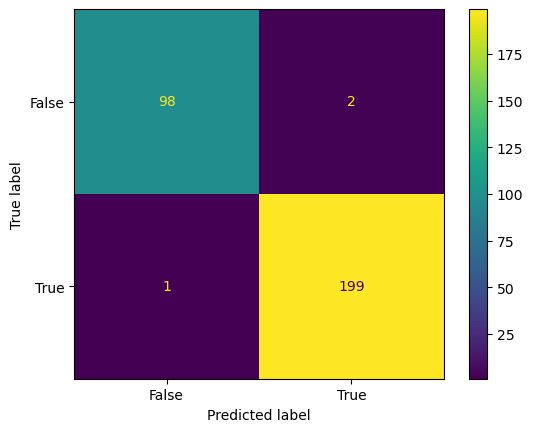

In [145]:
# Matrice de confusion
cm = confusion_matrix(y_test_mlr,pred_mlr_rf, labels=labels_cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_cm)
disp.plot()
plt.show()

#### Mesures d'évaluation du modèle

AUC for our classifier is: 0.9875


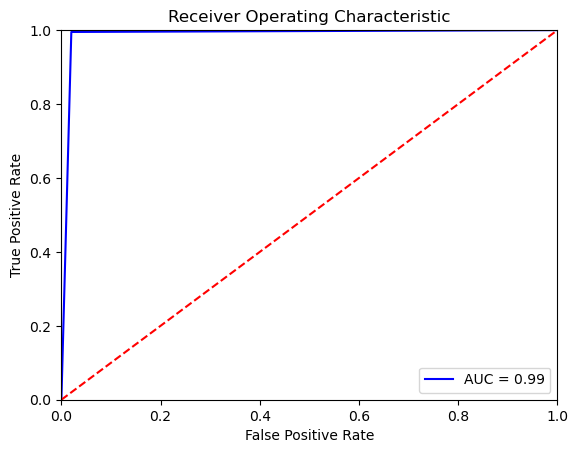

In [146]:
# Courbe ROC et AUC(Area Under the ROC)
fpr, tpr, threshold = roc_curve(y_test_mlr, pred_mlr_rf)
roc_auc = auc(fpr, tpr)

# Printing AUC
print(f"AUC for our classifier is: {roc_auc}")

# Plotting the ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [147]:
from sklearn.metrics import f1_score, r2_score

In [148]:
# récupération des valeurs de la matrice de confusion pour le calcul du score de spécificité
tn, fp, fn, tp = cm.ravel()

In [149]:
accuracy = round(accuracy_score(y_test_mlr,pred_mlr_rf),3)
precision = round(precision_score(y_test_mlr,pred_mlr_rf),3)
sensibilite = round(recall_score(y_test_mlr,pred_mlr_rf),3)
specificite = round(tn/(tn+fp),3)
f1_score = round(f1_score(y_test_mlr,pred_mlr_rf),3)
r2_score = round(r2_score(y_test_mlr.astype(int),pred_mlr_rf.astype(int)),3)

In [150]:
eval_rf_mlr_df = pd.DataFrame({'Modèle': ['Random Forest'],
                                   'Imputation NaN' : ['Régression linéaire multiple'],
                                   'Accuracy' :accuracy,
                                   'Précision' : precision,
                                   'Sensibilité' : sensibilite,
                                   'Spécificité': specificite,                               
                                   'f1_score' : f1_score,
                                   'R2 score': r2_score,
                                   'AUC' : roc_auc })
eval_rf_mlr_df

Modèle                Imputation NaN  Accuracy  Précision  \
0  Random Forest  Régression linéaire multiple      0.99       0.99   

   Sensibilité  Spécificité  f1_score  R2 score     AUC  
0        0.995         0.98     0.993     0.955  0.9875

## <font color='green'>6. Comparaison des modèles<a class="anchor" id="4_6"></a></font> 

In [151]:
# dataframe avec tous les mesures d'évaluation des différents modèles
df_eval = eval_dum_mlr_df.copy()
df_eval = pd.concat([df_eval,eval_log_mlrs_df],ignore_index=True)
df_eval = pd.concat([df_eval,eval_log_optim_df],ignore_index=True)
df_eval = pd.concat([df_eval,eval_kmeans_mlr_df],ignore_index=True)
df_eval = pd.concat([df_eval,eval_rf_mlr_df],ignore_index=True)

df_eval

Modèle                 Imputation NaN  \
0                     Dummy Classifier   Régression linéaire multiple   
1                Régression logistique   Régression linéaire multiple   
2  Régression logistique - seuil = 0.6   Régression linéaire multiple   
3                              k-means  Régression linéaire mulitiple   
4                        Random Forest   Régression linéaire multiple   

   Accuracy  Précision  Sensibilité  Spécificité  f1_score  R2 score     AUC  
0     0.667      0.667        1.000         0.00     0.800    -0.500  0.5000  
1     0.990      0.995        0.990         0.99     0.992     0.955  0.9900  
2     0.990      1.000        0.985         1.00     0.992     0.955  0.9925  
3     0.990      0.995        0.990         0.99     0.992     0.955  0.9900  
4     0.990      0.990        0.995         0.98     0.993     0.955  0.9875

Tous les modèles testés permettent d'obtenir des résultats supérieurs au dummy classifier.

**Critère de sélection du modèle** : 
* le meilleur à classer les vrais billets comme vrais mais aussi commettre le minimum d'erreur en faux positifs, c'est-à-dire qu'il doit avoir la meilleure proportion de prédictions correctes parmi les billets qui ont été prédits comme vrai et donc la meilleure précision.
* le plus simple, le plus facile à implémenter et à expliquer

**Modèle retenu** : Le modèle de régression logistique optimisé est celui qui a la meilleure précision et c'est un modèle simple et facile à implémenter.

*Note : voir le Notebook complet pour l'impact de l'imputation des valeurs manquantes*

# <font color='blue'>Partie 5 - Modèle final <a class="anchor" id="partie5"></a></font>

## Inspection du fichier 'billets_production'

In [152]:
# Importation du fichier test
billets_test = pd.read_csv('billets_production.csv')

In [153]:
billets_test

diagonal  height_left  height_right  margin_low  margin_up  length   id
0    171.76       104.01        103.54        5.21       3.30  111.42  A_1
1    171.87       104.17        104.13        6.00       3.31  112.09  A_2
2    172.00       104.58        104.29        4.99       3.39  111.57  A_3
3    172.49       104.55        104.34        4.44       3.03  113.20  A_4
4    171.65       103.63        103.56        3.77       3.16  113.33  A_5

Le fichier 'billets_production' contient les 6 variables dimensionnelles et une colonne 'id'.

## Définition de la fonction de détection de faux billets

In [154]:
def detection_fx_billets(model, nom_fichier):
    """
    Fonction permettant la détection de faux billets à partir d'un algorithme de classification déjà entraîné
    """
    
    # Importation des données
    df = pd.read_csv(nom_fichier)
    
    # Sélection des données significatives de la régression logistique
    X = df[['height_right','margin_low','margin_up','length']]
    
    # Standardisation des données
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X.values)
    
    # Prédictions et probabilités
    pred = model.predict(X_scaled)
    predict_proba = model.predict_proba(X_scaled)[:,1]
    threshold_optim = 0.6 # Définition du seuil
    y_pred = (predict_proba >= threshold_optim) # Classification en fonction du seuil
    
    # Affichage des résultats
    df_pred = df.copy()
    df_pred['prediction'] = y_pred
    df_pred['probabilité vrai %'] = np.round(predict_proba*100,2)

    return df_pred

## Test sur le fichier 'billets_production'

In [155]:
detection_fx_billets(reg_log2, 'billets_production.csv')

diagonal  height_left  height_right  margin_low  margin_up  length   id  \
0    171.76       104.01        103.54        5.21       3.30  111.42  A_1   
1    171.87       104.17        104.13        6.00       3.31  112.09  A_2   
2    172.00       104.58        104.29        4.99       3.39  111.57  A_3   
3    172.49       104.55        104.34        4.44       3.03  113.20  A_4   
4    171.65       103.63        103.56        3.77       3.16  113.33  A_5   

   prediction  probabilité vrai %  
0       False                0.23  
1       False                0.09  
2       False                0.07  
3        True              100.00  
4        True              100.00